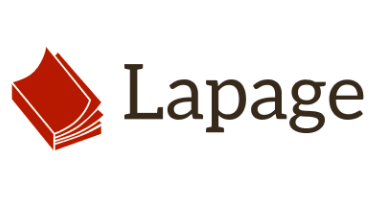

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pylab as pl
import numpy as np
import plotly.express as px
import statistics
from datetime import datetime, date
from scipy import stats
from scipy.stats import pareto
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from abc_analysis import abc_analysis, abc_plot
from scipy.stats import chi2_contingency
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from scipy.stats import levene
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Scénario
Vous êtes consultant Data Analyst chez Lapage, une grande librairie généraliste en ligne très réputée. Vous êtes directement rattaché au service Marketing.
Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. Vous intervenez car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

# Mission

Une analyse des différents indicateurs de vente, qui a été demandée directement par Antoine. Je t’ai mis en pièce jointe l’e-mail qu’il m’a envoyé résumant ses demandes.
<br>
* Identifier les différents indicateurs et graphiques autour du chiffre d'affaires. 
* Analyser l’évolution dans le temps et mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale ?
* Faire un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.
Enfin, j’aimerais avoir quelques informations sur les profils de nos clients, et également la
répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.
Une analyse plus ciblée sur les clients : l’objectif serait cette fois-ci de comprendre le comportement de nos clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques. Pour cela, je t’invite à voir avec Julie, qui te précisera directement ses demandes à ce niveau.


Regarder en particulier :
* Le lien entre le genre d’un client et les catégories des livres achetés
* Le lien entre l’âge des clients et le montant total des achats
* La fréquence d’achat
* La taille du panier moyen et les catégories des livres achetés

**Détail du nettoyage des données : vous présenterez ici l’ensemble des choix et actions que vous avez réalisés afin d’obtenir un jeu de données exploitable.
Restitution de l’analyse : les chiffres clés, KPI, graphiques générés, corrélations calculées, etc.**

* Réaliser une analyse bivariée pour interpréter des données
* Réaliser un test statistique
* Analyser des séries temporelles

# Données
* Compréhension des données

## Compréhension des données
Chargement des 3 fichiers csv avec la fonction read_csv de Pandas
<br>Utilisation des fonctions **head(), info(), describe()**

In [2]:
df_customers= pd.read_csv("customers.csv")
df_products= pd.read_csv("products.csv")
df_transactions= pd.read_csv("transactions.csv")

In [3]:
df_customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [5]:
df_customers.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [6]:
df_products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [7]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [8]:
df_products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [9]:
df_transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [10]:
df_transactions.nunique()

id_prod         3267
date          679371
session_id    342316
client_id       8602
dtype: int64

In [11]:
df_transactions.describe()

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


# Nettoyage des données

## df_customers

In [12]:
df_customers.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [13]:
df_customers['sex'].value_counts()

f    4491
m    4132
Name: sex, dtype: int64

In [14]:
df_customers['birth'].value_counts()

2004    440
1979    215
1988    207
1986    203
1978    199
       ... 
1935      8
1932      6
1930      4
1931      4
1929      3
Name: birth, Length: 76, dtype: int64

In [15]:
df_customers['client_id'].value_counts()

c_1705    1
c_5334    1
c_99      1
c_6296    1
c_4017    1
         ..
c_7534    1
c_6108    1
c_5956    1
c_7159    1
c_7885    1
Name: client_id, Length: 8623, dtype: int64

In [16]:
df_customers['client_id'].nunique()

8623

In [17]:
df_customers[df_customers.duplicated(keep=False)]

,client_id,sex,birth



Pas doublons, les valeurs client_id sont uniques à 8623
<br> Le fichier df_customers est propre, sans valeurs aberantes == aucun nettoyage necessaire

## df_products

In [18]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [19]:
#fonction describe nous informe sur une valeur minimale à -1eur
df_products['price'].sort_values(ascending=True)

731      -1.00
2355      0.62
2272      0.62
370       0.66
1211      0.77
         ...  
2779    233.54
1436    236.99
394     247.22
724     254.44
947     300.00
Name: price, Length: 3287, dtype: float64

In [20]:
#filtre des rows ou le prix inférieur à 0
df_products[df_products['price']<0]

,id_prod,price,categ
731,T_0,-1.0,0


Nous identifions l'index 731 de notre fichier products ayant un prix = -1eur. Nous faisons le choix de laisser pour l'instant cet ID. Objectif voir l'impact de cet ID sur la table transactions puis la table customers

In [21]:
df_products["categ"].value_counts()

0    2309
1     739
2     239
Name: categ, dtype: int64

In [22]:
df_products["id_prod"].value_counts()

2_235    1
1_22     1
0_74     1
0_683    1
1_124    1
        ..
0_339    1
1_462    1
0_890    1
1_90     1
2_173    1
Name: id_prod, Length: 3287, dtype: int64

In [23]:
df_products["id_prod"].nunique()

3287

In [24]:
df_products[df_products.duplicated(keep=False)]

,id_prod,price,categ


Identification de la ligne 731 du fichier product ou le prix = -1.0 eur
<br>Pas doublons, les valeurs id prod sont uniques à 3286
<br> Modification du type de la feature categorie

## df_transactions

In [25]:
#head()
df_transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [26]:
#tail()
df_transactions.tail()

,id_prod,date,session_id,client_id
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227
679531,1_523,2022-09-28 01:12:01.973763,s_274568,c_3873


In [27]:
#nunique()
df_transactions.nunique()

id_prod         3267
date          679371
session_id    342316
client_id       8602
dtype: int64

In [28]:
#value_count sur date
df_transactions['date'].value_counts()

test_2021-03-01 02:30:02.237413    13
test_2021-03-01 02:30:02.237414     8
test_2021-03-01 02:30:02.237444     8
test_2021-03-01 02:30:02.237427     8
test_2021-03-01 02:30:02.237443     8
                                   ..
2021-07-06 05:53:36.674675          1
2022-08-02 04:38:31.739589          1
2022-07-20 03:38:28.764687          1
2022-03-27 15:07:35.705259          1
2021-03-19 20:00:50.868135          1
Name: date, Length: 679371, dtype: int64

In [29]:
# Isoler les dates commençant par 'test' avec la fonction split
df_transactions["date_test"] = df_transactions["date"].apply(
    lambda x: x.split('_')[0])

# visualisation de l'id_prod == Test
df_transactions_t0 = df_transactions[df_transactions['id_prod'] == 'T_0']
df_transactions_t0

,id_prod,date,session_id,client_id,date_test
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0,test
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0,test
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1,test
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0,test
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0,test
...,...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0,test
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1,test
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1,test
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1,test


In [30]:
#Filtre date == test 
df_transactions_date_test = df_transactions[df_transactions['date_test'] == 'test']

In [31]:
#fonction equals pour vérifier la similitude des deux dataframe, T_0 et date_test
df_transactions_t0.equals(df_transactions_date_test)

True

In [32]:
#Filtre avec les id_client correspondant aux tests : ct_0 et ct_01
clients_test=['ct_0' ,'ct_1']

#fonction isin dans la table Transactions
df_transactions_client_test = df_transactions[df_transactions['client_id'].isin(
    clients_test) == True]

df_transactions_client_test

,id_prod,date,session_id,client_id,date_test
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0,test
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0,test
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1,test
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0,test
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0,test
...,...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0,test
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1,test
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1,test
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1,test


In [33]:
#fonction equals pour vérifier la similitude des deux dataframe, T_0 et client_test
df_transactions_t0.equals(df_transactions_client_test)

True

In [34]:
# visualisation des session id s_0
df_transactions_s0 = df_transactions[df_transactions['session_id'] == 's_0']
df_transactions_s0

,id_prod,date,session_id,client_id,date_test
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0,test
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0,test
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1,test
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0,test
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0,test
...,...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0,test
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1,test
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1,test
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1,test


In [35]:
#fonction equals pour vérifier la similitude des deux dataframe, T_0 et s_0
df_transactions_t0.equals(df_transactions_s0)

True

Après avoir observer la présence de T_0 dans df_product, nous avons isolé cet id dans la table transactions
<br> Puis nous avons comparé **T_0** avec:
* les date commençant par **test** avec la fonction split
* les id_client **ct_0 et ct_1**
* les sessions id **s_0**

<br> Nous obtenons des dataframes identiques, nous faisons le choix de supprimer T_0, automatiquement toutes les dates commencant par test, les id client ct0 et ct1 et les sessions id s_0 seront éliminés de notre nouveau dataframe transaction

In [36]:
#elimination de l'id_prod == Test
df_transactions=df_transactions[df_transactions['id_prod']!='T_0']

In [37]:
# fonction split
df_transactions["Date"] = df_transactions["date"].apply(lambda x: x.split()[0])

# To datetime au lieu d'object
df_transactions.Date = pd.to_datetime(df_transactions.Date)

# verification des valeurs uniques
df_transactions.nunique()

id_prod         3266
date          679332
session_id    342315
client_id       8600
date_test     679332
Date             730
dtype: int64

In [38]:
# Nettoyage de dfTransaction de la feature temporaire 'date_test'
df_transactions.drop('date_test', axis=1, inplace=True)

### Actualisation table products sans T_0

In [39]:
#filtre sans T_0 dans product
df_products = df_products[df_products["id_prod"] != 'T_0']

In [40]:
#unique() et visualisation de id_prod dans df_products sans la valeur T_0
df_products.nunique()

id_prod    3286
price      1454
categ         3
dtype: int64

### Actualisation table customers sans ct_0 et ct_1

In [41]:
#fonction isin dans la table customers avec la liste client_test contenant ct_0 et ct_1
df_customers_client_test = df_customers[df_customers['client_id'].isin(
    clients_test) == True]

df_customers_client_test

,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


In [42]:
#fonction isin pour rejeter l'index 2735 et l'index 8494
df_customers = df_customers[df_customers['client_id'].isin(
    clients_test) == False]

In [43]:
#nunique()
df_customers.nunique()

client_id    8621
sex             2
birth          76
dtype: int64

## Verification des id prod
### id prod non présents dans notre table df_transation

Dans la table **transactions** nous avons:
* id_prod = 3266 contre dans la table product, id_prod = 3286 ; delta de 20 row 
* id_client = 8600 contre dans la table customer, id_client = 8621; delta de 21 row 

In [44]:
# Création d'une liste avec uniquement les id_prod de la table transaction
id_prod_in_transactions = df_transactions['id_prod'].to_list()

# methode isin
id_prod_transactions_in_products = df_products[df_products["id_prod"].isin(
    id_prod_in_transactions) == False]

# verification des id_prod unique
id_prod_transactions_in_products.nunique()

id_prod    21
price      19
categ       3
dtype: int64

In [45]:
# Somme produits non vendus
somme_id_prod_non_vendus = id_prod_transactions_in_products['price'].sum()

# Affichage avec la fonction print() somme produits non vendus
print(
    f'La valeur des id_prod non vendus est de : {round(somme_id_prod_non_vendus,2)} euros')

La valeur des id_prod non vendus est de : 795.28 euros


Il y a 21 id_prod qui ne sont pas presents dans notre table transaction. Nous supposons qu'il s'agit des produits non vendus. Ces premiers resultats devront permettre d'influencer notre gestion des stocks en eliminant ces produits de notre base de données
<br>
<br>En revanche, il y a un delta de 1, car nous devions retrouver ici nos 20 id_prod or nous avons 21 id_prod
<br>*Vérification du delta dans les id_prod de la table transaction*

In [46]:
# On exclut les 21 id_prod
df_products = df_products[df_products["id_prod"].isin(
    id_prod_in_transactions) == True]

# nunique()
df_transactions.nunique()

id_prod         3266
date          679332
session_id    342315
client_id       8600
Date             730
dtype: int64

### id prod de la table transaction non présents dans notre table df_products

In [47]:
# Création d'une liste avec uniquement les id_prod de la table transaction
id_prod_products = df_products['id_prod'].to_list()

# methode isin
id_prod_transactions = df_transactions[df_transactions["id_prod"].isin(
    id_prod_products) == False]

id_prod_transactions

,id_prod,date,session_id,client_id,Date
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,2022-09-23
10106,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,2022-07-23
11727,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,2022-12-03
15675,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,2021-08-16
16377,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,2022-07-16
...,...,...,...,...,...
669730,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,2021-08-25
670682,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,2022-03-06
671286,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,2022-05-16
675679,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,2022-02-11


In [48]:
# visualisation nunique pour observer id prod 0_2245 sur les autres features
id_prod_transactions.nunique()

id_prod         1
date          221
session_id    221
client_id     100
Date          194
dtype: int64

In [49]:
# visualisation de l'id prod 0_2245 dans la table df_product
df_products[df_products['id_prod']=='0_2245']

,id_prod,price,categ


Nous observons que l'id_prod **0_2245** de notre table transaction compte 221  rows
<br>En revanche, il n'est pas présent dans la table product d'ou le delta de 1 que nous avions précedemment
<br>Nous faisons le choix de préserver cet id_prod en rajoutant id_prod **0_2245** à notre df_products 
<br>Il appartient à la categ 0, pour la feature price, nous prenons la moyenne 

In [50]:
#calcul moyenne categ 0
df_products[df_products['categ']==0].mean()

id_prod         inf
price      11.71476
categ       0.00000
dtype: float64

In [51]:
#dictionnaire de la id_prod 0_2245
dict = {'id_prod':'0_2245' ,'price': 11.71 ,'categ':0}

#visualisation nouvelle rows
df_products = df_products.append(dict, ignore_index = True)

In [52]:
# nunique()
df_products.nunique()

id_prod    3266
price      1443
categ         3
dtype: int64

In [53]:
# nunique()
df_transactions.nunique()

id_prod         3266
date          679332
session_id    342315
client_id       8600
Date             730
dtype: int64

Nous obtenons une similitude du nombre des id_prod dans df transaction et df products avec 3266 id prod unique

## Verification des id_client
### id client dans df_transation

* id_client = 8600 dans la table transaction
* id_client = 8621 dans la table customer
<br>Delta de 21 row 

In [54]:
# Création d'une liste avec uniquement les id_client de la table transaction
id_client_in_transactions = df_transactions['client_id'].to_list()

# methode isin
id_client_transactions_in_customers = df_customers[df_customers["client_id"].isin(
    id_client_in_transactions) == False]

# verification des id_client unique
id_client_transactions_in_customers.nunique()

client_id    21
sex           2
birth        15
dtype: int64

In [55]:
id_client_transactions_in_customers['birth']

801     2001
2483    1997
2734    1998
2769    1967
2851    1959
3179    1956
3190    1992
3334    1992
3721    2004
3821    1999
4724    1965
4791    1963
6112    2002
6208    2004
6338    2003
6471    2004
6585    1956
6828    1960
7790    2001
7819    1993
8536    1956
Name: birth, dtype: int64

In [56]:
nombre_clients_sans_transaction = len(
    id_client_transactions_in_customers['client_id'])

In [57]:
# Affichage avec la fonction print() du nombre de clients sans transactions
print(
    f'Il y a : {nombre_clients_sans_transaction} clients ne figurent pas dans notre df_transaction')

Il y a : 21 clients ne figurent pas dans notre df_transaction


Il y a 21 client_id qui ne sont pas presents dans notre table transaction. Nous supposons qu'il s'agit des clients sans transaction associée.
<br> Ces clients manquants permettront de calculer le **taux d'attrition** sur la période

In [58]:
# Calcul taux d'attrition
taux_attrition=nombre_clients_sans_transaction/len(df_customers['client_id'])*100

# Affichage avec la fonction print() du taux d'attrition
print(
    f'Le taux d attrition est de : {round(taux_attrition,2)} %')

Le taux d attrition est de : 0.24 %


In [59]:
# On exclut les 21 id_client sans transactions avec la fonction isin()
df_customers = df_customers[df_customers["client_id"].isin(
    id_client_in_transactions) == True]

# Verification des id_clientunique
df_customers.nunique()

client_id    8600
sex             2
birth          76
dtype: int64

In [60]:
# nunique()
df_transactions.nunique()

id_prod         3266
date          679332
session_id    342315
client_id       8600
Date             730
dtype: int64

Nous avons terminé le nettoyage de nos données en eliminant les id_clients sans transaction associée
<br> Notre fichier df_customers et df_transactions comportent 8600 client_id
<br> Nous pouvons maintenant faire le rapprochement des tables

## Rapprochement des tables

Après la phase de nettoyage nous obtenons un jeu de donnée cohérent avec une similitude entre id_prod et id_client sur les 3 tables

In [61]:
df_transactions_customers = pd.merge(
    df_transactions, df_customers, on='client_id')
df_transactions_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  object        
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   Date        679332 non-null  datetime64[ns]
 5   sex         679332 non-null  object        
 6   birth       679332 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 41.5+ MB


In [62]:
df_transactions_customers_products = pd.merge(
    df_transactions_customers, df_products, on='id_prod')
df_transactions_customers_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  object        
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   Date        679332 non-null  datetime64[ns]
 5   sex         679332 non-null  object        
 6   birth       679332 non-null  int64         
 7   price       679332 non-null  float64       
 8   categ       679332 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 51.8+ MB


In [63]:
df_transactions_customers_products.head()

,id_prod,date,session_id,client_id,Date,sex,birth,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022-05-20,f,1986,4.18,0
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,2021-07-20,f,1986,4.18,0
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,2022-08-20,f,1986,4.18,0
3,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,2021-05-09,f,1968,4.18,0
4,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,2022-05-30,f,1968,4.18,0


In [64]:
df_transactions_customers_products.nunique()

id_prod         3266
date          679332
session_id    342315
client_id       8600
Date             730
sex                2
birth             76
price           1443
categ              3
dtype: int64

In [65]:
# duplicate
df_transactions_customers_products.loc[df_transactions_customers_products.duplicated(
    keep=False), :]

,id_prod,date,session_id,client_id,Date,sex,birth,price,categ


## Création de features 
### Time Series Indexing

Cette création de feature liées  l'intervale temporelle nous permettrons de faire des analyses dans le temps

In [66]:
# Set_index
df_transactions_customers_products = df_transactions_customers_products.set_index(
    'Date')

# création d'une nouvelle feature avec l'année
df_transactions_customers_products['ANNEE'] = df_transactions_customers_products.index.year

# création d'une nouvelle feature avec le nom du mois
df_transactions_customers_products['MOIS'] = df_transactions_customers_products.index.month_name(
)

# création d'une nouvelle feature avec le nom du jour
df_transactions_customers_products['JOUR'] = df_transactions_customers_products.index.day_name(
)

### Date.today 
L'objectif est d'obtenir une feature avec l'age des clients

In [67]:
# Birth date
today = date.today()
df_transactions_customers_products['age'] = df_transactions_customers_products.apply(
    lambda x: today.year-x['birth'], axis=1)

# Analyse CA
## Indicateurs et graphiques autour du chiffre d'affaires. 

In [68]:
# Calcul du CA total
CA_total = df_transactions_customers_products["price"].sum()

# Affichage CA  total avec la fonction print()
print(
    f'Le chiffre d’affaires total réalisé est de : {round(CA_total ,2)} euros')

Le chiffre d’affaires total réalisé est de : 11856316.59 euros


In [69]:
# Calcul du nombre de ventes
Nb_vente_total = df_transactions_customers_products["price"].count()

# Affichage nombre de ventes total avec la fonction print()
print(
    f'Le nombre total de ventes réalisé est de : {round(Nb_vente_total ,2)} articles')

Le nombre total de ventes réalisé est de : 679332 articles


In [70]:
CA_2021 = df_transactions_customers_products['price'].resample("Y").sum()[0]
CA_2022 = df_transactions_customers_products['price'].resample("Y").sum()[1]
CA_2023 = df_transactions_customers_products['price'].resample("Y").sum()[2]

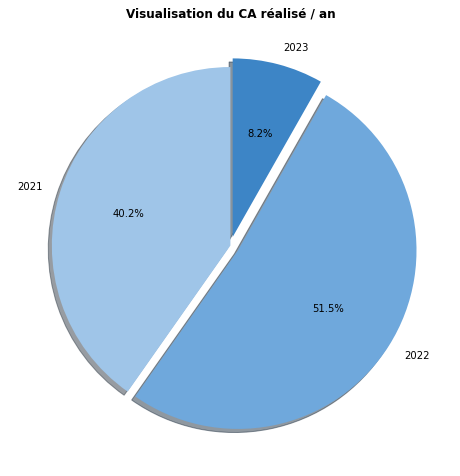

In [71]:
#pie
fig = plt.figure(figsize=[8, 12])
labels = '2021','2022','2023'

sizes = [CA_2021,CA_2022,CA_2023]

explode = (0, 0.05, 0.05)
ax = fig.add_subplot()

# add colors
colors = ['#9fc5e8','#6fa8dc','#3d85c6']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.set_title(
    'Visualisation du CA réalisé / an', fontweight="bold")
plt.show()

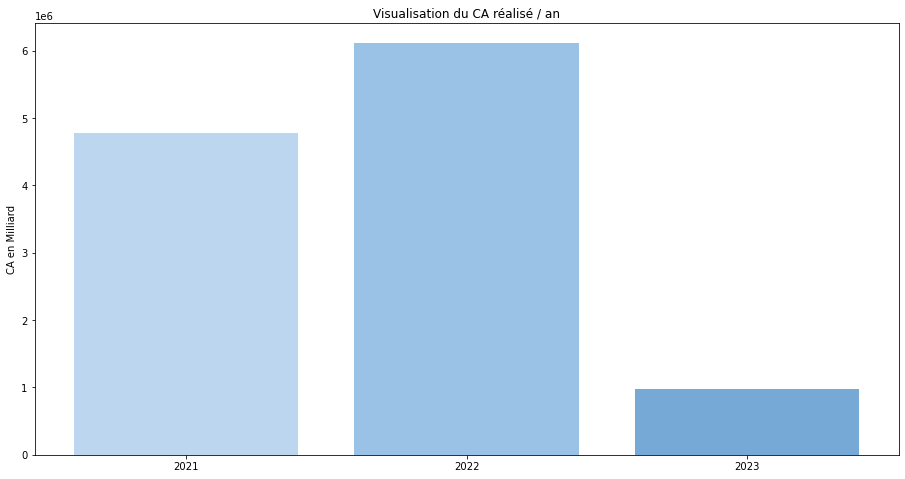

In [72]:
# visualisation avec barplot de matplotlib
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0, 0, 1, 1])
labels = '2021', '2022', '2023'
data = [CA_2021, CA_2022, CA_2023]

ax.bar(labels, data, color=['#9fc5e8', '#6fa8dc', '#3d85c6'], alpha=0.7)
ax.set_title('Visualisation du CA réalisé / an')
ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel('CA en Milliard')
plt.show()

In [73]:
# Affichage CA  réalisé /an avec la fonction print()
print(
    f'Le chiffre d’affaires réalisé en 2021 est de : {round(CA_2021,2)} euros')
print(
    f'Le chiffre d’affaires réalisé en 2022 est de : {round(CA_2022,2)} euros')
print(
    f'Le chiffre d’affaires réalisé en 2023 est de : {round(CA_2023,2)} euros')

Le chiffre d’affaires réalisé en 2021 est de : 4771845.33 euros
Le chiffre d’affaires réalisé en 2022 est de : 6110087.01 euros
Le chiffre d’affaires réalisé en 2023 est de : 974384.25 euros


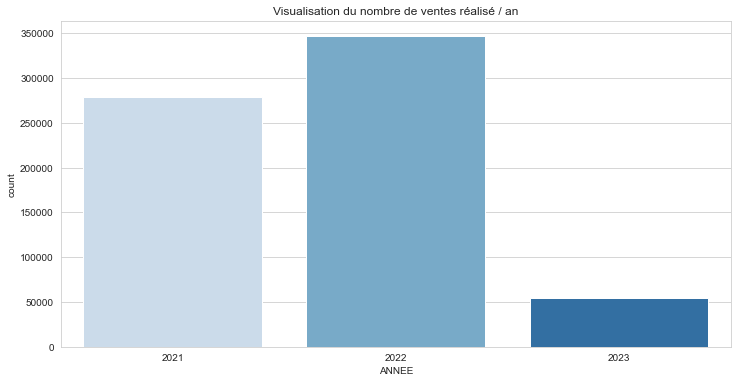

In [74]:
fig = plt.figure(figsize=(12,6))
sns.set_style('whitegrid')
sns.countplot(x='ANNEE', data=df_transactions_customers_products, palette='Blues').set(title='Visualisation du nombre de ventes réalisé / an')
plt.show()

In [75]:
# groupby
nb_vente_produits_an = df_transactions_customers_products.groupby('ANNEE')[
    'price'].count()

# Nb ventes 2021
nb_vente_produits_2021 = nb_vente_produits_an.iloc[0]

# Nb ventes 2022
nb_vente_produits_2022 = nb_vente_produits_an.iloc[1]

# Nb ventes 2023
nb_vente_produits_2023 = nb_vente_produits_an.iloc[2]

In [76]:
# Affichage nombre de ventes total avec la fonction print()
print(
    f'Le nombre de ventes réalisées en 2021 est de : {nb_vente_produits_2021} articles')
print(
    f'Le nombre de ventes réalisées en 2022 est de : {nb_vente_produits_2022} articles')
print(
    f'Le nombre de ventes réalisées en 2023 est de : {nb_vente_produits_2023} articles')

Le nombre de ventes réalisées en 2021 est de : 278335 articles
Le nombre de ventes réalisées en 2022 est de : 346500 articles
Le nombre de ventes réalisées en 2023 est de : 54497 articles


## Time Series Forecasting

 
* Permet de faire des predictions sur les tendances futures
* On note que la moyenne n'est pas aussi forte sur octobre 2021


## Prédictions & ARIMA

In [77]:
#CA data
df_CA = df_transactions_customers_products['price'].resample(
    "M").sum()

#dataframe
df_CA = pd.DataFrame(df_CA)

# rename columns
df_CA.columns = ['CA']

# 18 data as train
train = df_CA[0:18]

# 6 data as test
test = df_CA[18:]

### Seasonal decompose

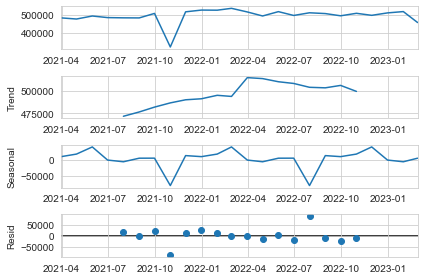

In [78]:
#Addictive
decomposition = sm.tsa.seasonal_decompose(df_CA,model='addictive',freq=9)
fig= decomposition.plot()
plt.show()

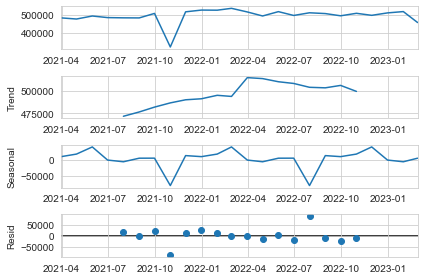

In [79]:
#Multiplicative
decomposition = sm.tsa.seasonal_decompose(df_CA,model='Multiplicative',freq=9)
fig= decomposition.plot()
plt.show()

### Holt Winters Model
Lissage exponentiel de Holt-Winters

In [80]:
#Model with train data
hwmodel=ExponentialSmoothing(train.CA,trend='add',seasonal='mul',seasonal_periods=4).fit()

#pred
test_pred=hwmodel.forecast(6)

# show test pred
test_pred

2022-09-30    532958.102832
2022-10-31    527712.485491
2022-11-30    530313.932559
2022-12-31    527708.297565
2023-01-31    550719.201781
2023-02-28    545153.464218
Freq: M, dtype: float64

<AxesSubplot:xlabel='Date'>

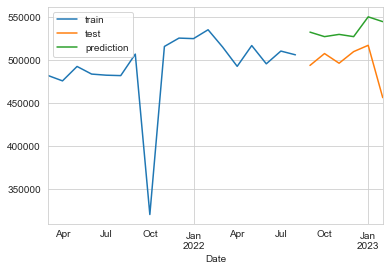

In [81]:
#plot
train['CA'].plot(legend=True,label='train')
test['CA'].plot(legend=True,label='test')
test_pred.plot(legend=True,label='prediction')

In [82]:
#Model Final
final_model=ExponentialSmoothing(df_CA,trend='add',seasonal='mul',seasonal_periods=4).fit()

#pred
pred=final_model.forecast(10)

<AxesSubplot:xlabel='Date'>

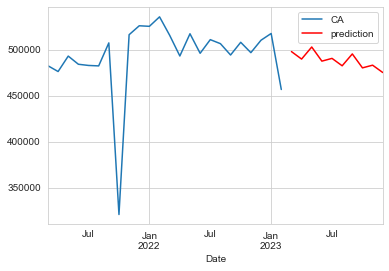

In [83]:
#plot
df_CA['CA'].plot(legend=True,label='CA')
pred.plot(legend=True,label='prediction',color='red')

### ARIMA 
le modèle ARIMA est tout simplement une combinaison d’un processus AR et d’un processus MA.
<BR>Le I du modèle ARIMA signifie ‘integrated’ pour intégration. En différenciant les séries temporelles, il est possible de retirer les tendances qu’elles présentent pour les stationnariser.

#### Moving Average (MA model)
MA signifie ‘moving average’ ou en français moyenne mobile.
<br>
<br>Choix de moyenne mobile sur 3 mois en raison de trop peu de données, notre échantillon s'étend sur seulement 24 mois de **Mars 2021 à Fevrier 2023**
<br>
<br>Une moyenne mobile permet de lisser une série de valeurs exprimées en fonction du temps (série chronologique). Elle permet d'éliminer les fluctuations les moins significatives.

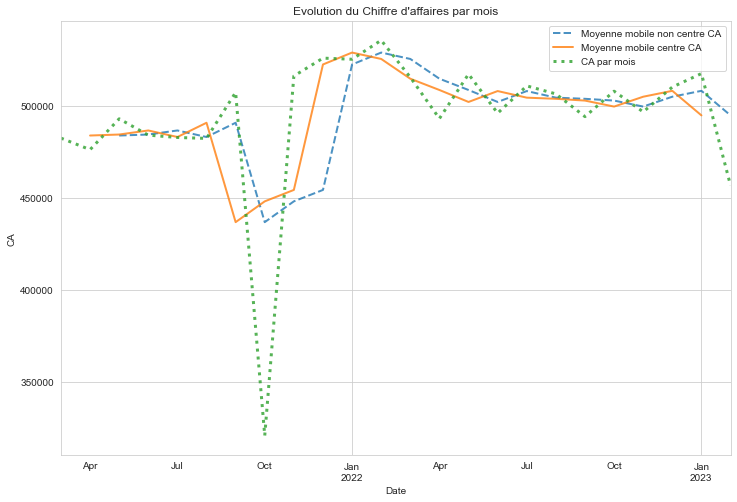

In [84]:
plt.figure(figsize=(12, 8))
df_CA['CA'].rolling(window=3).mean().plot(
    label='Moyenne mobile non centre CA', lw=2, ls='--', alpha=0.8)
df_CA['CA'].rolling(window=3,center=True).mean().plot(
    label='Moyenne mobile centre CA', lw=2, ls='-', alpha=0.8)
df_transactions_customers_products['price'].resample('M').sum().plot(
    label='CA par mois', lw=3, ls=':', alpha=0.8)
plt.ylabel("CA")
plt.title("Evolution du Chiffre d'affaires par mois")
plt.legend()
plt.show()

#### Auto Regressive (AR model)
Le processus AR signifie autorégressif.

In [85]:
#model
model_ar = AR(train)
model_ar_fit=model_ar.fit()

#predict
predictions=model_ar_fit.predict(start=len(train),end=len(df_CA)-1)

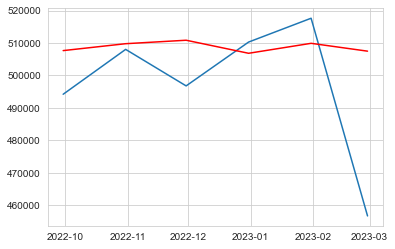

In [86]:
#plot
plt.plot(test)
plt.plot(predictions,color='red')

#### ARIMA Model

In [87]:
from statsmodels.tsa.arima_model import ARIMA

In [88]:
# ARIMA model
model = ARIMA(train, order=(2, 0, 0)).fit()

# pred
pred = model.predict(start=len(train), end=len(df_CA)-1)

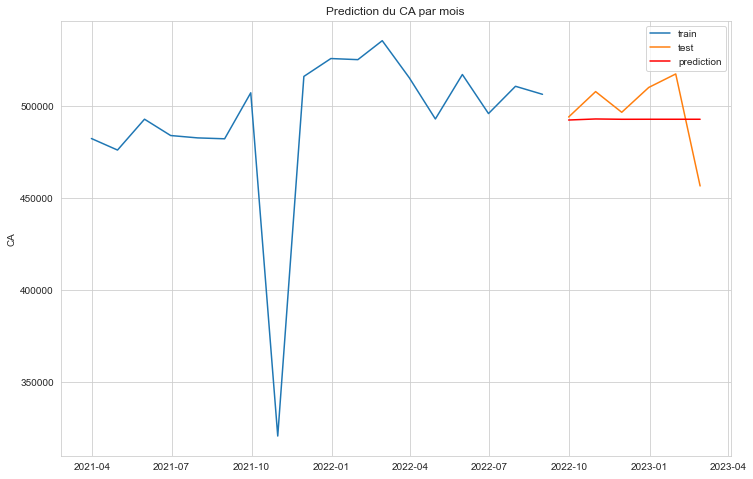

In [89]:
plt.figure(figsize=(12, 8))
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(pred,label='prediction', color='red')
plt.ylabel("CA")
plt.title("Prediction du CA par mois")
plt.legend()
plt.show()

In [90]:
#Predict future data
final_model = ARIMA(df_CA,order=(2, 0, 0)).fit() #build on full dataset

In [91]:
# pred with final model
prediction = final_model.predict(start=len(df_CA), end=len(df_CA)+6)

In [92]:
import itertools
p=range(0,4)
q=range(0,4)
d=range(0,4)

In [93]:
pdq_combination=list(itertools.product(p,d,q))
len(pdq_combination)

64

In [94]:
rmse=[]
order1=[]

for pdq in pdq_combination:
    try:
        model=ARIMA(train,order=pdq).fit()
        pred=model.predict(start=len(train),end=len(df_CA)-1)
        error=np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)
    except:
        continue

In [95]:
results=pd.DataFrame(index=order1,data=rmse,columns=['RMSE'])

In [96]:
results.sort_values(by='RMSE',ascending=True).iloc[0]

RMSE    20234.002926
Name: (2, 0, 0), dtype: float64

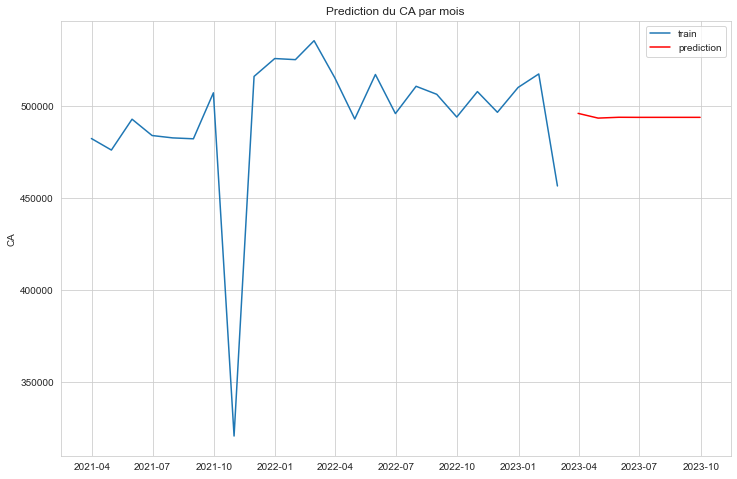

In [97]:
plt.figure(figsize=(12, 8))
plt.plot(df_CA,label='train')
plt.plot(prediction,label='prediction', color='red')
plt.ylabel("CA")
plt.title("Prediction du CA par mois")
plt.legend()
plt.show()

#### ACF PACF

In [98]:
from matplotlib.pyplot import *

<Figure size 864x432 with 0 Axes>

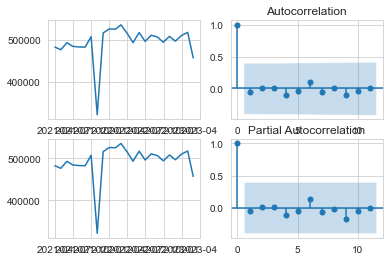

In [99]:
fig = plt.figure(figsize=(12, 6))
fig,axes=plt.subplots(2,2)
axes[0,0].plot(df_CA)
plot_acf(df_CA, lags=11, ax=axes[0,1])
axes[1,0].plot(df_CA)
plot_pacf(df_CA,lags=11, ax=axes[1,1])
plt.show()

Dans le domaine du Machine Learning, il existe une collection de techniques permettant de manipuler et d’interpréter des variables qui dépendent du temps. Parmi celles-ci, ARIMA peut supprimer la composante de tendance afin de prédire avec précision les valeurs futures.
<br>
<br>Plus récemment les réseaux de neurones sont devenus de plus en plus utilisés pour la prédiction des séries temporelles car ils viennent corriger certains défauts des méthodes ‘classiques’ comme l’ARIMA.

### Evolution par mois (hist)

In [100]:
# Resample par mois pour chaque categorie

df_transactions_customers_products_mois_categ_0 = df_transactions_customers_products[
    df_transactions_customers_products['categ'] == 0].resample('M').sum()

df_transactions_customers_products_mois_categ_1 = df_transactions_customers_products[
    df_transactions_customers_products['categ'] == 1].resample('M').sum()

df_transactions_customers_products_mois_categ_2 = df_transactions_customers_products[
    df_transactions_customers_products['categ'] == 2].resample('M').sum()

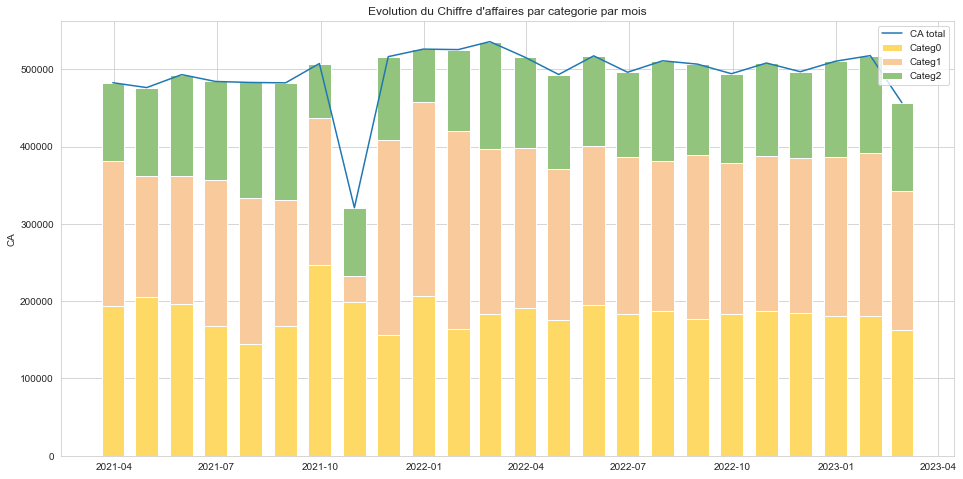

In [101]:
# visualisation hist
fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot()
# Define Data
Date = df_transactions_customers_products_mois_categ_0.index
Categ0 = df_transactions_customers_products_mois_categ_0['price']
Categ1 = df_transactions_customers_products_mois_categ_1['price']
Categ2 = df_transactions_customers_products_mois_categ_2['price']

# Define width of stacked chart
w = 20

# Plot stacked bar chart
ax.bar(Date, Categ0, w, color = "#ffd966")
ax.bar(Date, Categ1, w, bottom=Categ0,color = "#f9cb9c")
ax.bar(Date, Categ2, w, bottom=Categ0+Categ1,color = "#93c47d")
ax.plot(df_CA)

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["CA total","Categ0","Categ1","Categ2"])

# Display
plt.tick_params(axis='x')
plt.title("Evolution du Chiffre d'affaires par categorie par mois")
plt.show()

### Visualisation des données ou le CA est anormalement bas

In [102]:
# Visulation resample Jour du 29 septembre au 29 octobre 2021
df_transactions_customers_products_loc_29_sept_29_oct_2021 = df_transactions_customers_products.loc[
    '2021-09-29':'2021-10-29']
# Somme CA du 29 septembre au 29 octobre 2021
df_transactions_customers_products_loc_29_sept_29_oct_2021_SOMME = df_transactions_customers_products_loc_29_sept_29_oct_2021['price'].resample(
    'D').sum()

In [103]:
# Resample Jour du 29 septembre au 29 octobre 2021 par categorie

df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_0 = df_transactions_customers_products_loc_29_sept_29_oct_2021[
    df_transactions_customers_products_loc_29_sept_29_oct_2021['categ'] == 0].resample('D').sum()

df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_1 = df_transactions_customers_products_loc_29_sept_29_oct_2021[
    df_transactions_customers_products_loc_29_sept_29_oct_2021['categ'] == 1].resample('D').sum()

df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_2 = df_transactions_customers_products_loc_29_sept_29_oct_2021[
    df_transactions_customers_products_loc_29_sept_29_oct_2021['categ'] == 2].resample('D').sum()

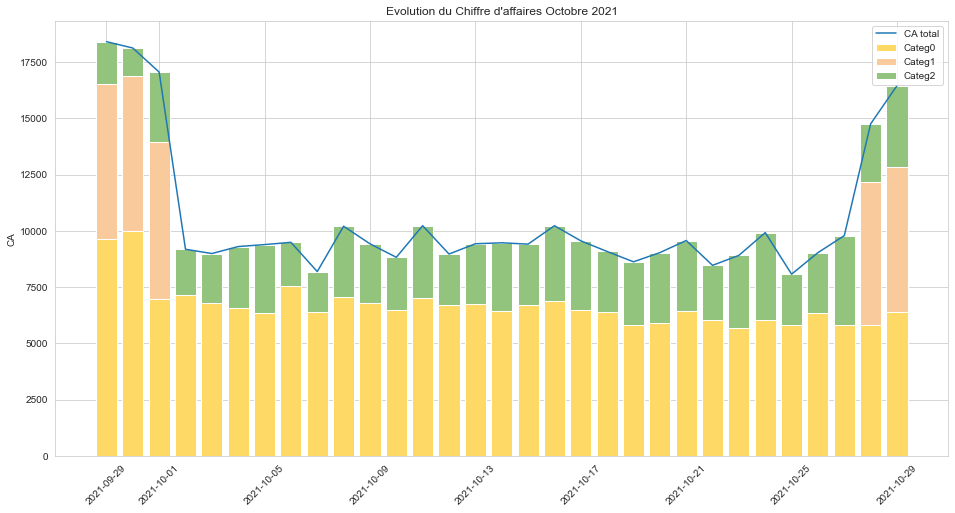

In [104]:
# visualisation hist
fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot()
# Define Data
Date = df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_0.index
Categ0 = df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_0['price']
Categ1 = df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_1['price']
Categ2 = df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_2['price']

# Define width of stacked chart

# Plot stacked bar chart
ax.bar(Date, Categ0, color = "#ffd966")
ax.bar(Date, Categ1, bottom=Categ0,color = "#f9cb9c")
ax.bar(Date, Categ2, bottom=Categ0+Categ1,color = "#93c47d")
ax.plot(df_transactions_customers_products_loc_29_sept_29_oct_2021_SOMME)

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["CA total","Categ0","Categ1","Categ2"])

# Display
plt.tick_params(axis='x',rotation = 45)
plt.title("Evolution du Chiffre d'affaires Octobre 2021")
plt.show()

Les valeurs de la categorie 1 sont nulles **du 2 au 27 octobre inclus**, certainement une erreur. Nous pouvons nuancer notre caclul précédent concernant de chiffre d'affaires avec ce manque de données
<br> Nous pouvons emetre des hypothèses ( rupture de stock livres de la categorie 1, données non transmises..)

## Faire un zoom sur les références, 
### Les Tops et les Flops sur l'ensemble des produits

In [105]:
# Groupby id_prod et sort_value price ascending false
df_transactions_customers_products_id_prod = df_transactions_customers_products.groupby(
    'id_prod')['price'].sum().sort_values(ascending=False)

# selection des 20 premières valeurs
df_transactions_customers_products_id_prod_top_20 = df_transactions_customers_products_id_prod[
    :20]

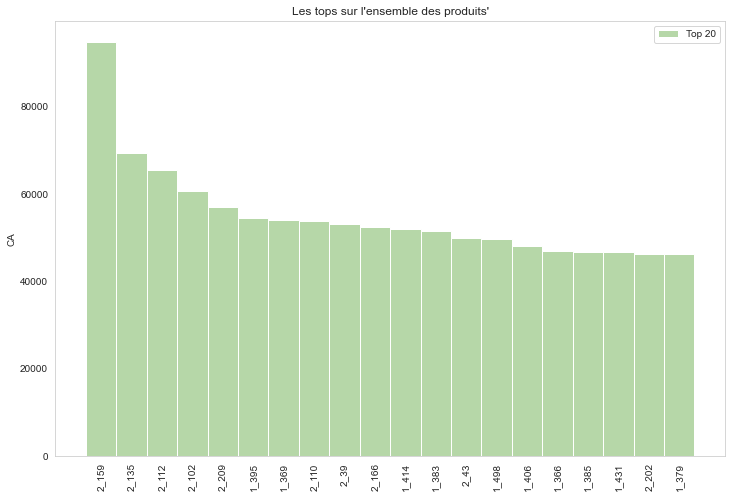

In [106]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_top_20.index
top20 = df_transactions_customers_products_id_prod_top_20.values

# Bar
plt.bar(id_prod, top20, w,color = "#b6d7a8")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Top 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les tops sur l'ensemble des produits'")
plt.grid()
plt.show()

Nous observons que les produits de la categ 2 sont ceux qui composent le top de notre classement sur l'ensemble des références. Comme nous pouvions le voir precedement il s'agit de la categorie ou la quantité de produits vendus est la plus faible avec seulement 6% des produits soit 36483 produits

In [107]:
# Groupby id_prod et sort_value price ascending true
df_transactions_customers_products_id_prod = df_transactions_customers_products.groupby(
    'id_prod')['price'].sum().sort_values(ascending=True)

# selection des 20 premières valeurs
df_transactions_customers_products_id_prod_flop_20 = df_transactions_customers_products_id_prod[
    :20]

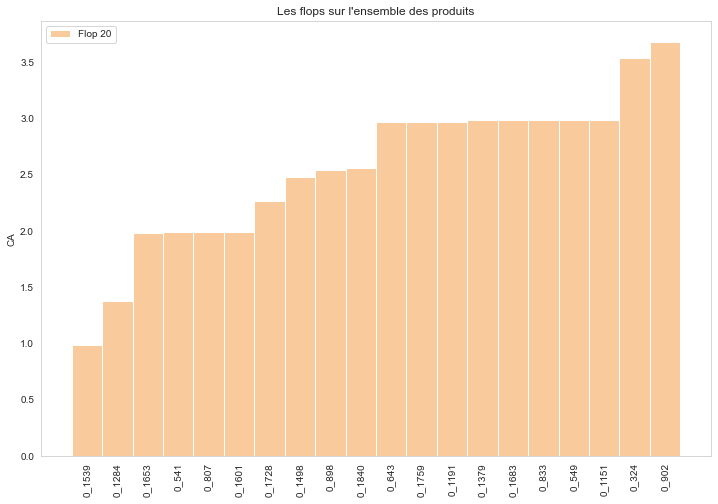

In [108]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_flop_20.index
flop20 = df_transactions_customers_products_id_prod_flop_20.values

# Bar
plt.bar(id_prod, flop20, w,color = "#f9cb9c")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Flop 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les flops sur l'ensemble des produits")
plt.grid()
plt.show()

Tandis que les produits de la categorie 0 composent le flop 20 du classement sur l'ensemble des produits. Comme nous pouvions le voir precedement il s'agit de la categorie ou la quantité de produits vendus est la plus forte avec 61% des produits soit 415459 produits

## Les tops et les flops par categorie

### Top Categorie 0,1 et 2

In [109]:
# Groupby id_prod et sort_value price ascending false
df_transactions_customers_products_id_prod_categ = df_transactions_customers_products.groupby(
    ['id_prod', 'categ'])['price'].sum().sort_values(ascending=False)

# pd to dataframe
df_transactions_customers_products_id_prod_categ = pd.DataFrame(
    df_transactions_customers_products_id_prod_categ)

# reset index categ
df_transactions_customers_products_id_prod_categ = df_transactions_customers_products_id_prod_categ.reset_index(
    'categ')

# fillna
df_transactions_customers_products_id_prod_categ = df_transactions_customers_products_id_prod_categ.fillna(
    0)

In [110]:
# filtre categ O
df_transactions_customers_products_id_prod_categ_0 = df_transactions_customers_products_id_prod_categ[
    df_transactions_customers_products_id_prod_categ['categ'] == 0]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_categ_0_top_20 = df_transactions_customers_products_id_prod_categ_0[
    :20]

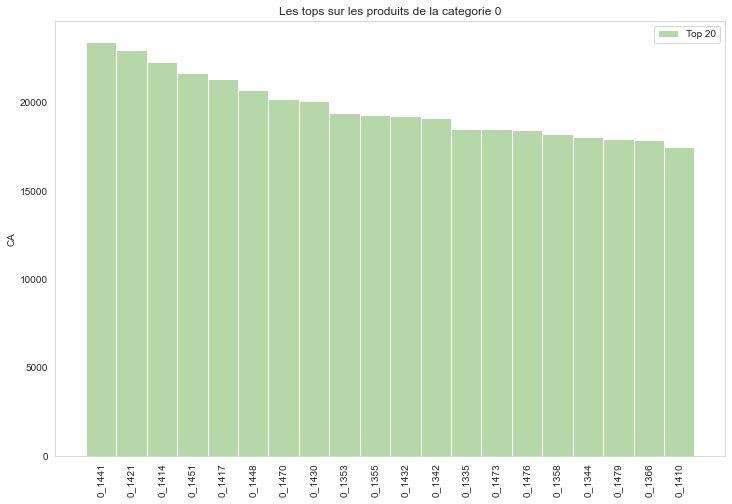

In [111]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_categ_0_top_20.index
top20 = df_transactions_customers_products_id_prod_categ_0_top_20['price'].values

# Bar
plt.bar(id_prod, top20, w,color = "#b6d7a8")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Top 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les tops sur les produits de la categorie 0")
plt.grid()
plt.show()

In [112]:
# filtre categ 1
df_transactions_customers_products_id_prod_categ_1 = df_transactions_customers_products_id_prod_categ[
    df_transactions_customers_products_id_prod_categ['categ'] == 1]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_categ_1_top_20 = df_transactions_customers_products_id_prod_categ_1[
    :20]

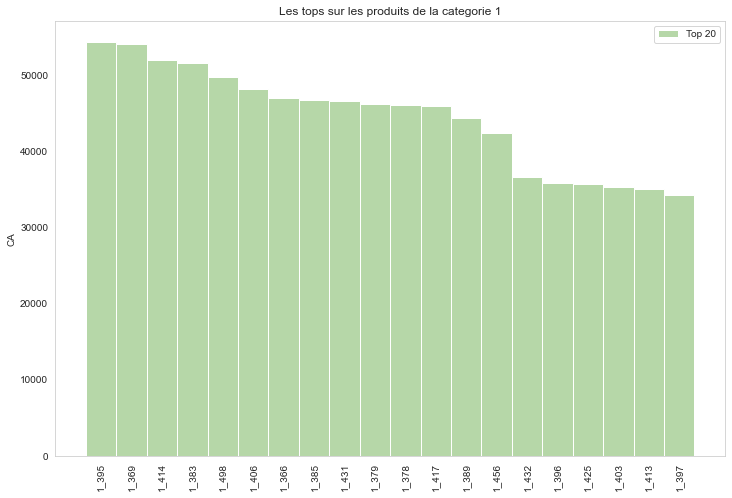

In [113]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_categ_1_top_20.index
top20 = df_transactions_customers_products_id_prod_categ_1_top_20['price'].values

# Bar
plt.bar(id_prod, top20, w,color = "#b6d7a8")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Top 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les tops sur les produits de la categorie 1")
plt.grid()
plt.show()

In [114]:
# filtre categ 1
df_transactions_customers_products_id_prod_categ_2 = df_transactions_customers_products_id_prod_categ[
    df_transactions_customers_products_id_prod_categ['categ'] == 2]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_categ_2_top_20 = df_transactions_customers_products_id_prod_categ_2[
    :20]

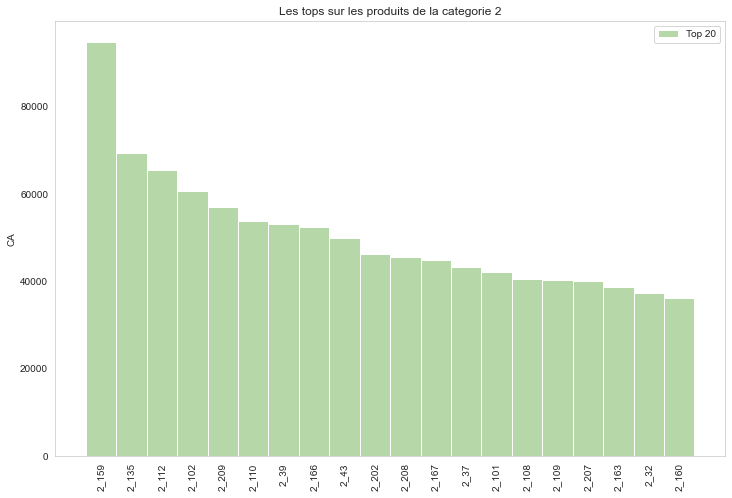

In [115]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_categ_2_top_20.index
top20 = df_transactions_customers_products_id_prod_categ_2_top_20['price'].values

# Bar
plt.bar(id_prod, top20, w,color = "#b6d7a8")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Top 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les tops sur les produits de la categorie 2")
plt.grid()
plt.show()

Nous observons un interet très marqué pour un produit id_prod = 2_159, ce produit réalise 650 ventes avec un prix unitaire 145.99 eur
<br> Il s'agit des produits ou il faut maintenir une couverture de stock importante car ils réalisent les meilleurs ventes


### Flop Categorie 0,1 et 2

In [116]:
# Groupby id_prod et sort_value price ascending false
df_transactions_customers_products_id_prod_categ_flop = df_transactions_customers_products.groupby(
    ['id_prod', 'categ'])['price'].sum().sort_values(ascending=True)

# pd to dataframe
df_transactions_customers_products_id_prod_categ_flop  = pd.DataFrame(
    df_transactions_customers_products_id_prod_categ_flop )

# reset index categ
df_transactions_customers_products_id_prod_categ_flop  = df_transactions_customers_products_id_prod_categ_flop .reset_index(
    'categ')

# fillna
df_transactions_customers_products_id_prod_categ_flop  = df_transactions_customers_products_id_prod_categ_flop .fillna(
    0)

In [117]:
# filtre categ 0
df_transactions_customers_products_id_prod_flop_categ_0 = df_transactions_customers_products_id_prod_categ_flop[
    df_transactions_customers_products_id_prod_categ_flop['categ'] == 0]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_flop_categ_0_top_20 = df_transactions_customers_products_id_prod_flop_categ_0[
    :20]

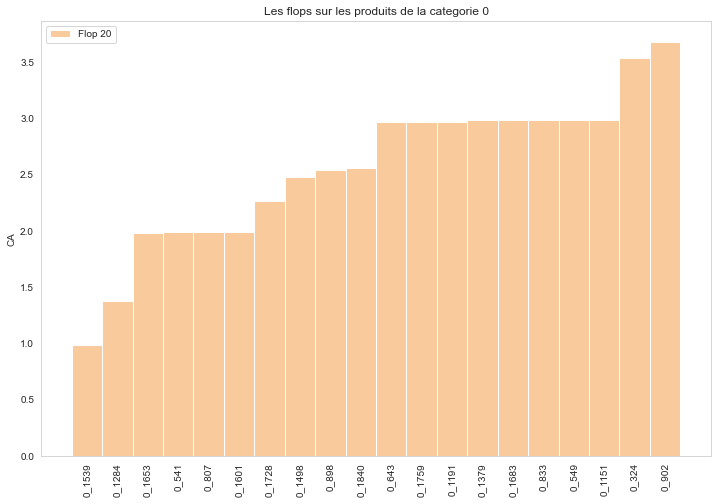

In [118]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_flop_categ_0_top_20.index
categ_0_flop = df_transactions_customers_products_id_prod_flop_categ_0_top_20['price'].values

# Bar
plt.bar(id_prod, categ_0_flop, w,color = "#f9cb9c")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Flop 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les flops sur les produits de la categorie 0")
plt.grid()
plt.show()

In [119]:
# filtre categ 1
df_transactions_customers_products_id_prod_flop_categ_1 = df_transactions_customers_products_id_prod_categ_flop[
    df_transactions_customers_products_id_prod_categ_flop['categ'] == 1]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_flop_categ_1_top_20 = df_transactions_customers_products_id_prod_flop_categ_1[
    :20]

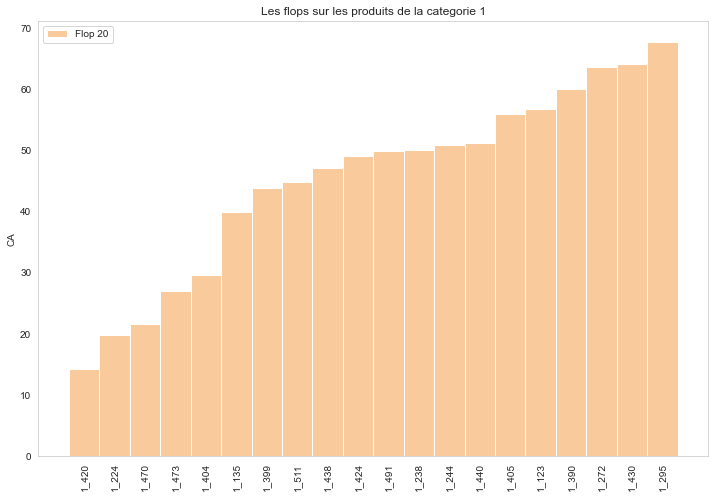

In [120]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_flop_categ_1_top_20.index
categ_1_flop = df_transactions_customers_products_id_prod_flop_categ_1_top_20['price'].values

# Bar
plt.bar(id_prod, categ_1_flop, w,color = "#f9cb9c")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Flop 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les flops sur les produits de la categorie 1")
plt.grid()
plt.show()

In [121]:
# filtre categ 2
df_transactions_customers_products_id_prod_flop_categ_2 = df_transactions_customers_products_id_prod_categ_flop[
    df_transactions_customers_products_id_prod_categ_flop['categ'] == 2]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_flop_categ_2_top_20 = df_transactions_customers_products_id_prod_flop_categ_2[
    :20]

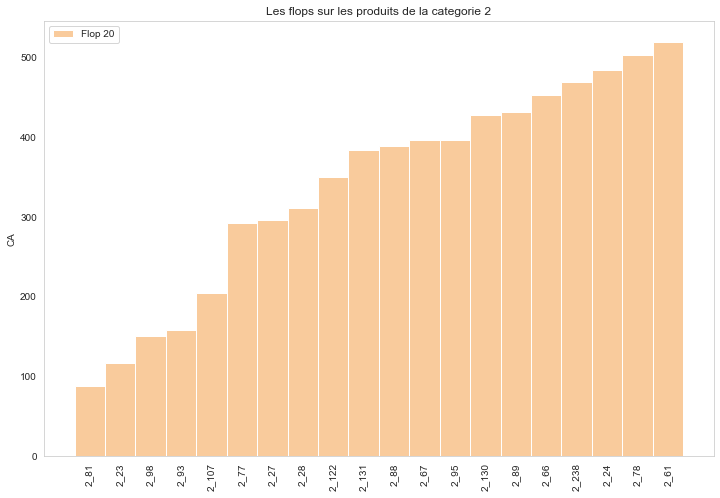

In [122]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_flop_categ_2_top_20.index
categ_2_flop = df_transactions_customers_products_id_prod_flop_categ_2_top_20['price'].values

# Bar
plt.bar(id_prod, categ_2_flop, w,color = "#f9cb9c")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Flop 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les flops sur les produits de la categorie 2")
plt.grid()
plt.show()

Nous observons dans les flops: les faible ventes, nous pourrions avoir une petite couverture de stock ou eliminer ces produits qui ne trouvent pas leur cible

## La répartition par catégorie sur l'ensemble de la période

In [123]:
# Affichage CA par catégorie avec la fonction groupby()
CA_categ = df_transactions_customers_products.groupby('categ')['price'].sum()

# pd to dataframe
CA_categ = pd.DataFrame(CA_categ)

# rename colonne
CA_categ = CA_categ.rename(columns={'price': 'CA'})

In [124]:
CA_categ_0=CA_categ['CA'].loc[0]
CA_categ_1=CA_categ['CA'].loc[1]
CA_categ_2=CA_categ['CA'].loc[2]

In [125]:
# Affichage CA par categorie avec la fonction print()
print(
    f'Le chiffre d’affaires réalisé par la catégorie 0 est de : {round(CA_categ_0,2)} euros')
print(
    f'Le chiffre d’affaires réalisé par la catégorie 1 est de : {round(CA_categ_1,2)} euros')
print(
    f'Le chiffre d’affaires réalisé par la catégorie 2 est de : {round(CA_categ_2,2)} euros')

Le chiffre d’affaires réalisé par la catégorie 0 est de : 4422318.88 euros
Le chiffre d’affaires réalisé par la catégorie 1 est de : 4653722.69 euros
Le chiffre d’affaires réalisé par la catégorie 2 est de : 2780275.02 euros


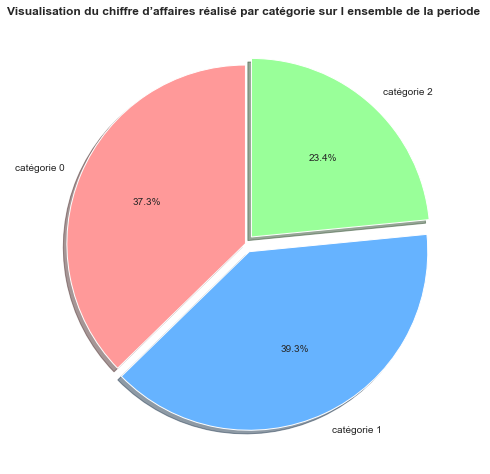

In [126]:
fig = plt.figure(figsize=[8, 12])
labels = 'catégorie 0', 'catégorie 1', 'catégorie 2'

sizes = [CA_categ_0,
         CA_categ_1,
         CA_categ_2]

explode = (0, 0.05, 0.05)
ax = fig.add_subplot()

# add colors
colors = ['#ff9999', '#66b3ff', '#99ff99']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title(
    'Visualisation du chiffre d’affaires réalisé par catégorie sur l ensemble de la periode ', fontweight="bold")
plt.show()

In [127]:
#Affichage nombre de ventes par catégorie avec la fonction groupby()
Nb_vente_categ=df_transactions_customers_products.groupby('categ')['price'].count()

In [128]:
#Affichage nombre de ventes par catégorie avec la fonction groupby()
Nb_vente_categ=df_transactions_customers_products.groupby('categ')['price'].count()

#Affichage nb ventes par categorie avec la fonction print()
print(f'Le nombre total de ventes réalisés par la catégorie 0 est de : {round(Nb_vente_categ[0],2)} produits')
print(f'Le nombre total de ventes réalisés par la catégorie 1 est de : {round(Nb_vente_categ[1],2)} produits')
print(f'Le nombre total de ventes réalisés par la catégorie 2 est de : {round(Nb_vente_categ[2],2)} produits')

Le nombre total de ventes réalisés par la catégorie 0 est de : 415680 produits
Le nombre total de ventes réalisés par la catégorie 1 est de : 227169 produits
Le nombre total de ventes réalisés par la catégorie 2 est de : 36483 produits


[Text(0.5, 1.0, 'Visualisation du nombre de ventes réalisé / categorie sur l ensemble de la période')]

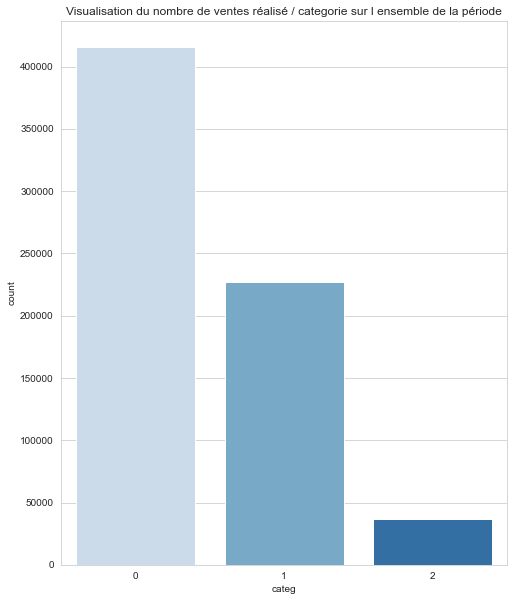

In [129]:
fig = plt.figure(figsize= [8,10])
sns.set_style('whitegrid')
sns.countplot(x='categ', data=df_transactions_customers_products, palette='Blues').set(title='Visualisation du nombre de ventes réalisé / categorie sur l ensemble de la période')

### Prix en fonction des catégories

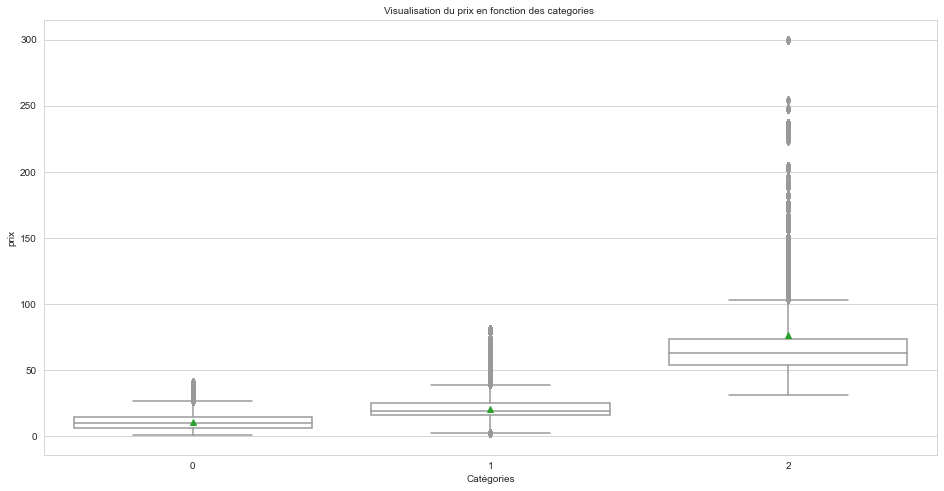

In [130]:
#Visualisation boxplot
fig = plt.figure(figsize=[16, 8])
sns.boxplot(x="categ", y="price", data=df_transactions_customers_products, showmeans=True,color='white')
plt.title("Visualisation du prix en fonction des categories ",size=10)
plt.ylabel('prix', fontsize = 10)
plt.xlabel('Catégories', fontsize = 10)
plt.show()


## Informations sur les profils de nos clients

### Les meilleurs clients par en fonction du CA (Courbe de Lorenz)

In [131]:
# Groupby id_prod et sort_value price ascending false
df_transactions_customers_products_id_client = df_transactions_customers_products.groupby(
    'client_id')['price'].sum().sort_values(ascending=False)


# pd to dataframe
df_transactions_customers_products_id_client = pd.DataFrame(
    df_transactions_customers_products_id_client)

# rename colonne
df_transactions_customers_products_id_client = df_transactions_customers_products_id_client.rename(columns={
                                                                                                   'price': 'CA'})

In [132]:
# Concentration CA (Lorenz)
dep = df_transactions_customers_products_id_client['CA']
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0], lorenz)  # La courbe de Lorenz commence à 0

# Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
AUC = (lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2)/n
S = 0.5 - AUC  # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S, 2)
gini

0.45

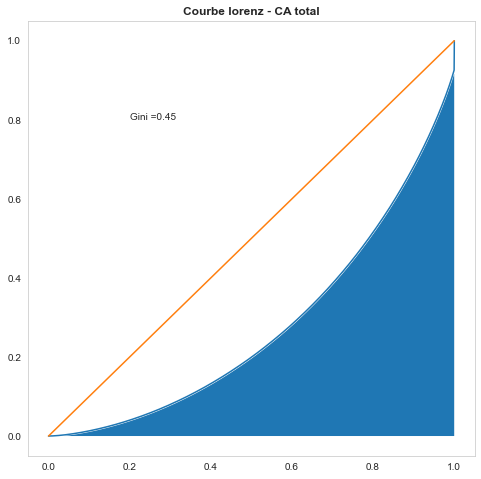

In [133]:
# Graphique concentration dU CA
plt.figure(figsize=[8, 8])
xaxis = np.linspace(0-1/n, 1+1/n, n+1)
plt.plot(xaxis, lorenz)
ident = [0.0, 1.0]
plt.plot(ident, ident)
plt.fill_between(np.linspace(0, 1, len(lorenz)), lorenz)
plt.text(0.2, 0.8, "Gini =" + str(gini))
plt.title("Courbe lorenz - CA total", fontweight="bold")
ax.set_xlabel("Produit")
ax.set_ylabel("CA")
plt.grid()
plt.show()

Grace à la courbe de Lorenz, nous pouvons observer que la répartition est inégalitaire, moins de 1% des clients representent 10% du CA 
<br>Nous allons analyser plus précisément les meilleurs clients

### Les meilleurs clients par en fonction du CA

In [134]:
# selection des 20 meilleurs clients
df_transactions_customers_products_id_client_top20 = df_transactions_customers_products_id_client[
    :20]

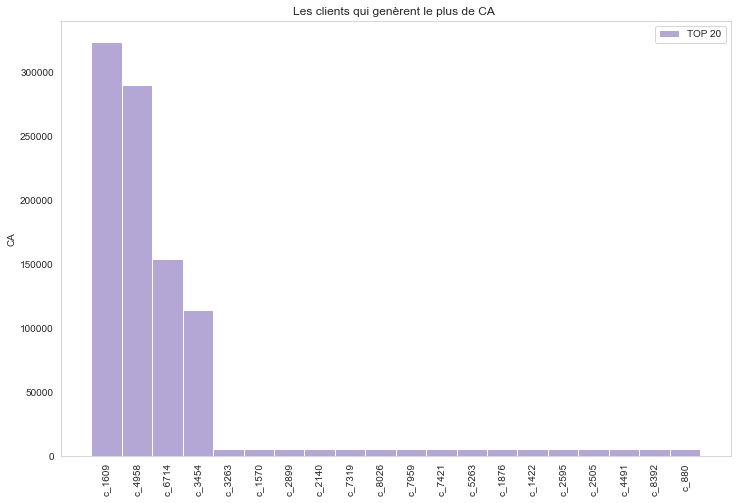

In [135]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
client_id = df_transactions_customers_products_id_client_top20.index
top_20 = df_transactions_customers_products_id_client_top20['CA'].values

# Bar
plt.bar(client_id, top_20, w, color="#b4a7d6")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["TOP 20"])

# Display
plt.tick_params(axis='x', rotation=90)
plt.title("Les clients qui genèrent le plus de CA ")
plt.grid()
plt.show()

<AxesSubplot:xlabel='CA'>

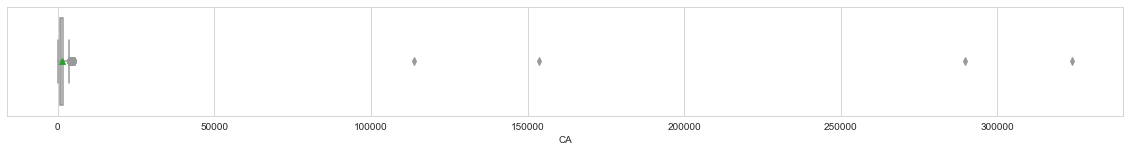

In [136]:
pl.figure(figsize=(20, 2))
sns.boxplot(x='CA',
            data=df_transactions_customers_products_id_client,
            color='white',
            showmeans=True)

On peut voir très nettement que 4 clients generent une très grosse part de CA: au delà des 100 000eur
* c_1609
* c_4958
* c_6714
* c_3454

### Les meilleurs clients par en fonction du nombre d'achat

In [137]:
# Groupby id_prod et sort_value price ascending false
df_transactions_customers_products_id_client_count = df_transactions_customers_products.groupby(
    'client_id')['price'].count().sort_values(ascending=False)


# pd to dataframe
df_transactions_customers_products_id_client_count = pd.DataFrame(
    df_transactions_customers_products_id_client_count)

# rename colonne
df_transactions_customers_products_id_client_count = df_transactions_customers_products_id_client_count.rename(columns={
                                                                                                               'price': 'Nb_ventes'})

# selection des 20 meilleurs clients par en fonction du nombre de vente
df_transactions_customers_products_id_client_count_top20 = df_transactions_customers_products_id_client_count[
    :20]

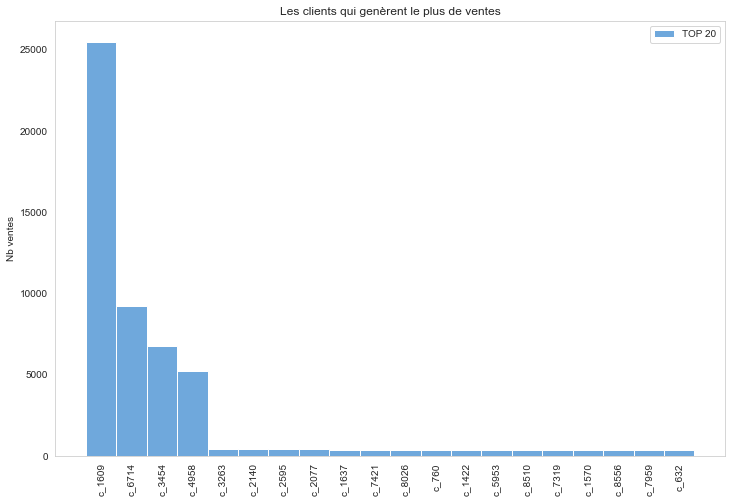

In [138]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
client_id = df_transactions_customers_products_id_client_count_top20.index
top_20 = df_transactions_customers_products_id_client_count_top20['Nb_ventes'].values

# Bar
plt.bar(client_id, top_20, w, color="#6fa8dc")

# Add labels
plt.ylabel("Nb ventes")

# Add legend
plt.legend(["TOP 20"])

# Display
plt.tick_params(axis='x', rotation=90)
plt.title("Les clients qui genèrent le plus de ventes")
plt.grid()
plt.show()

<AxesSubplot:xlabel='Nb_ventes'>

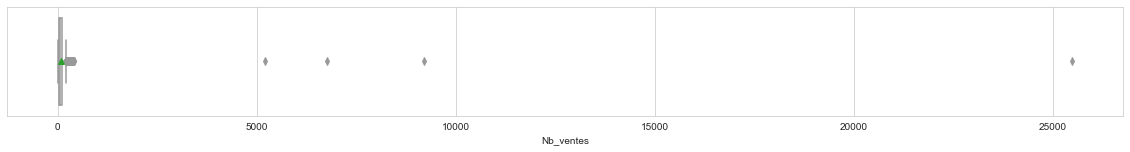

In [139]:
pl.figure(figsize=(20, 2))
sns.boxplot(x='Nb_ventes',
            data=df_transactions_customers_products_id_client_count,
            color='white',
            showmeans=True)

On peut voir très nettement que les 4 clients generant une très grosse part de CA, sont également les meilleurs clients par en fonction du nombre d'achat
* c_1609
* c_4958
* c_6714
* c_3454

### Définir les outliers CA en fonction id_clients

#### Calculer la moyenne

In [140]:
# calcul moyenne
moyenne_ca_id_client = df_transactions_customers_products_id_client['CA'].mean()

# print()
print(
    f'La Moyenne du CA en fonction de id_client est de : {round(moyenne_ca_id_client,2)} euros')

La Moyenne du CA en fonction de id_client est de : 1378.64 euros


#### Calculer la mediane

In [141]:
# calcul median
median_ca_id_client = df_transactions_customers_products_id_client['CA'].median()

# print
print(
    f'La Mediane du CA en fonction de id_client est de : {round(median_ca_id_client,2)} euros')

La Mediane du CA en fonction de id_client est de : 1027.27 euros


#### Calculer les quantiles

In [142]:
# On calcule le quantile 0,25 qui est le quartile Q1
Q1 = round(np.percentile(
    df_transactions_customers_products_id_client['CA'], 25))
print("Quartile Q1 vaut : ", Q1)

Quartile Q1 vaut :  548


In [143]:
# On calcule le quantile 0,75 qui est le quartile Q3
Q3 = round(np.percentile(
    df_transactions_customers_products_id_client['CA'], 75))
print("Quartile Q3 vaut : ", Q3)

Quartile Q3 vaut :  1780


#### L’écart interquartile

In [144]:
# L ecart interquartile est Q3 - Q1
print("L ecart interquartile vaut : ", Q3 - Q1)

L ecart interquartile vaut :  1232


In [145]:
#fonction pour definir les outliers
IQR = Q3 - Q1

low = Q1 - 1.5 * IQR 
high = Q3 + 1.5 * IQR 

low,high

(-1300.0, 3628.0)

In [146]:
#outliers inférieurs 
outliers_min = df_transactions_customers_products_id_client[
    df_transactions_customers_products_id_client['CA'] < low]

#outliers supérieurs
outliers_max = df_transactions_customers_products_id_client[
    df_transactions_customers_products_id_client['CA'] > high]

In [147]:
# definir le nombre d'outliers min
print(f'Il y a {len(outliers_min)} outliers < min')

# definir le nombre d'outliers max
print(f'Il y a {len(outliers_max)} outliers > max')

Il y a 0 outliers < min
Il y a 246 outliers > max


 Il y a 246 outliers mathématiques avec comme vu précedement 4 outliers **business** en termes dépenses et de nombre d'achats
 <br> Pour la suite de notre étude, nous faisons le choix de distinguer ces 4 clients business (BtoB)
 <br> Pour poursuivre notre analyse nous faisons le choix d'utilier les données en excluant les 4 clients business c'est à dire en gardant uniquement les clients individuels (BtoC)

### BtoB - BtoC

In [148]:
# definition list avec les clients btob
top_client={'c_1609','c_4958','c_6714','c_3454'}

In [149]:
# Df BtoC
df_transactions_customers_products_btoc = df_transactions_customers_products[df_transactions_customers_products["client_id"].isin(
    top_client) == False]

# Df BtoB
df_transactions_customers_products_btob = df_transactions_customers_products[df_transactions_customers_products["client_id"].isin(
    top_client) == True]

In [150]:
# Calcul du CA total BtoC
CA_total_btoc = df_transactions_customers_products_btoc["price"].sum()

# Affichage CA  total avec la fonction print()
print(
    f'Le chiffre d’affaires total réalisé par les clients BtoC est de : {round(CA_total_btoc ,2)} euros')

Le chiffre d’affaires total réalisé par les clients BtoC est de : 10975180.66 euros


In [151]:
# Calcul du CA total BtoB
CA_total_btob = df_transactions_customers_products_btob["price"].sum()

# Affichage CA  total avec la fonction print()
print(
    f'Le chiffre d’affaires total réalisé par les clients BtoB est de : {round(CA_total_btob  ,2)} euros')

Le chiffre d’affaires total réalisé par les clients BtoB est de : 881135.93 euros


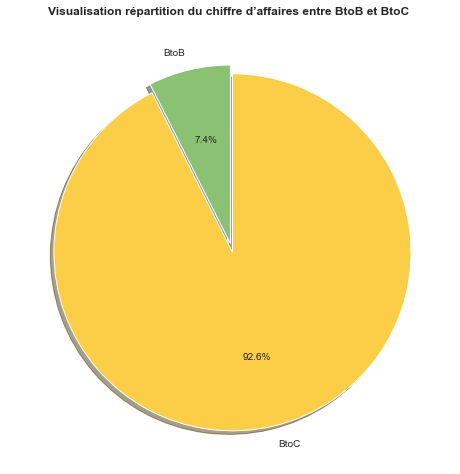

In [152]:
fig = plt.figure(figsize=[8, 12])
labels = 'BtoB', 'BtoC'

sizes = [CA_total_btob,
         CA_total_btoc]

explode = (0, 0.05)
ax = fig.add_subplot()

# add colors
colors = [ '#8bc173', '#fcce47']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title(
    'Visualisation répartition du chiffre d’affaires entre BtoB et BtoC ', fontweight="bold")
plt.show()

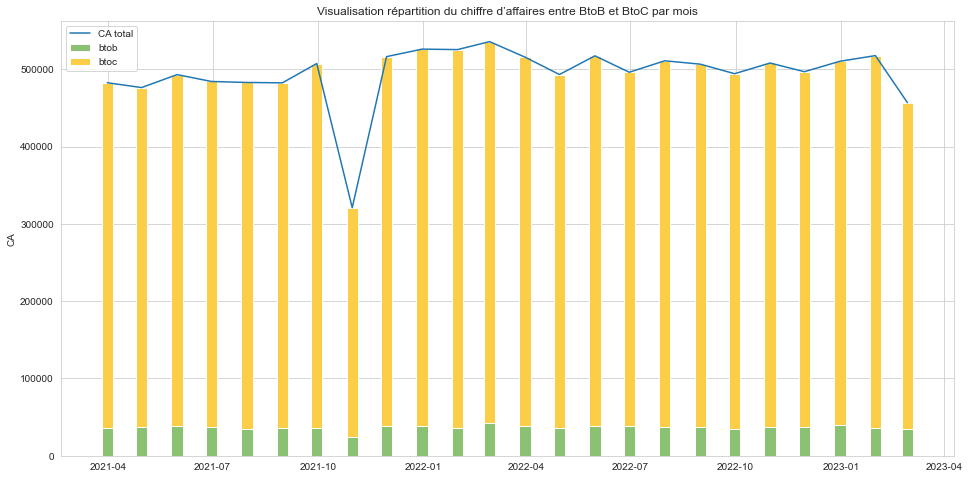

In [153]:
#resample somme par mois
df_transactions_customers_products_btob_CA = df_transactions_customers_products_btob['price'].resample(
    'M').sum()

df_transactions_customers_products_btoc_CA = df_transactions_customers_products_btoc['price'].resample(
    'M').sum()


# visualisation hist
fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot()

# Define Data
Date = df_transactions_customers_products_btob_CA.index
btob = df_transactions_customers_products_btob_CA
btoc = df_transactions_customers_products_btoc_CA

# Define width of stacked chart
w = 10

# Plot stacked bar chart
ax.bar(Date, btob, w, color="#8bc173")
ax.bar(Date, btoc, w, bottom=btob, color="#fcce47")
ax.plot(df_CA)

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["CA total", "btob", "btoc"])

# Display
plt.tick_params(axis='x')
plt.title("Visualisation répartition du chiffre d’affaires entre BtoB et BtoC par mois")
plt.show()

## La répartition du chiffre d'affaires  par catégorie en fonction du profil client *(Clients BtoB)*

* CA réalisé en fonction de l'age des clients
* CA réalisé en fonction de l'age des clients par categories
* CA réalisé en fonction des tranches d'age des clients
* CA réalisé en fonction du genre des clients
* CA réalisé en fonction du sexe par produits


### CA réalisé en fonction de l'age des clients

<AxesSubplot:xlabel='birth', ylabel='count'>

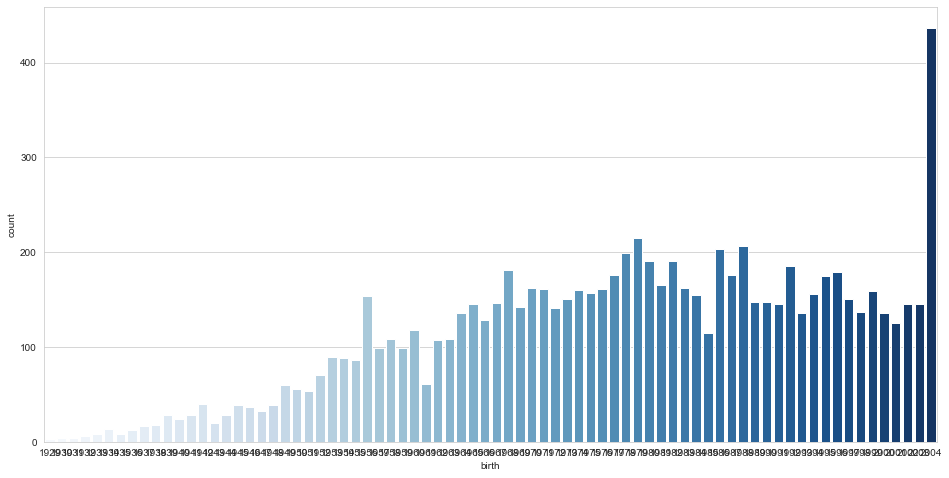

In [154]:
fig = plt.figure(figsize=[16, 8])
sns.set_style('whitegrid')
sns.countplot(x='birth', data=df_customers, palette='Blues')

En reprenant notre fichier df_customers, nous pouvons observer que les personnes agées née en 2004 donc à l'age de 18 ans sont les nombreux dans notre fichier client

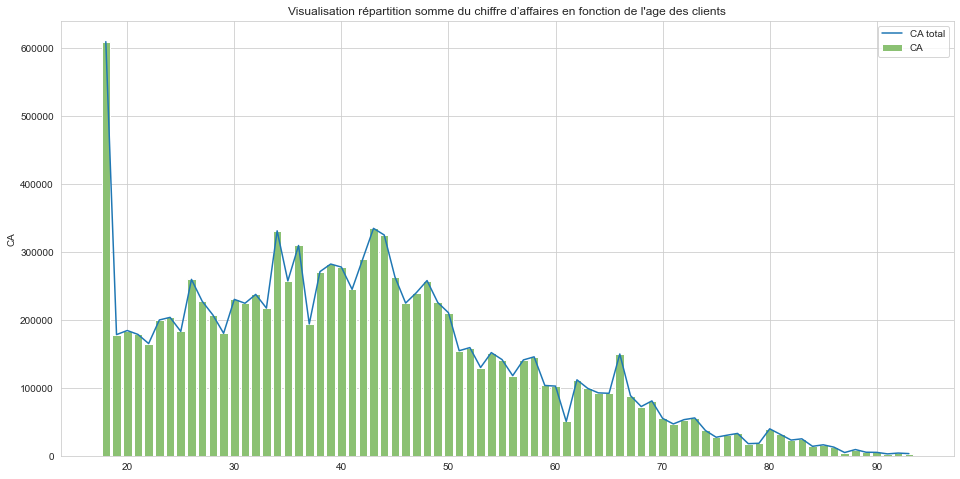

In [155]:
# Definition de du df_age_CA
df_age_CA = df_transactions_customers_products_btoc.groupby('age')['price'].sum()

# visualisation hist
fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot()

# Define Data
age = df_age_CA.index
CA = df_age_CA

# Plot stacked bar chart
ax.bar(age, CA, color="#8bc173")
ax.plot(df_age_CA)

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["CA total", "CA"])

# Display
plt.tick_params(axis='x')
plt.title(
    "Visualisation répartition somme du chiffre d’affaires en fonction de l'age des clients")
plt.show()

les personnes agées avec l'age de 18 ans sont également ceux qui génèrent le plus de CA
Tandis qu'a partir de 45 ans, plus on avance dans l'age moins le CA généré est elevé. Notre librairie en ligne ne trouve pas forcement sa cible chez les seniors

<AxesSubplot:xlabel='age', ylabel='count'>

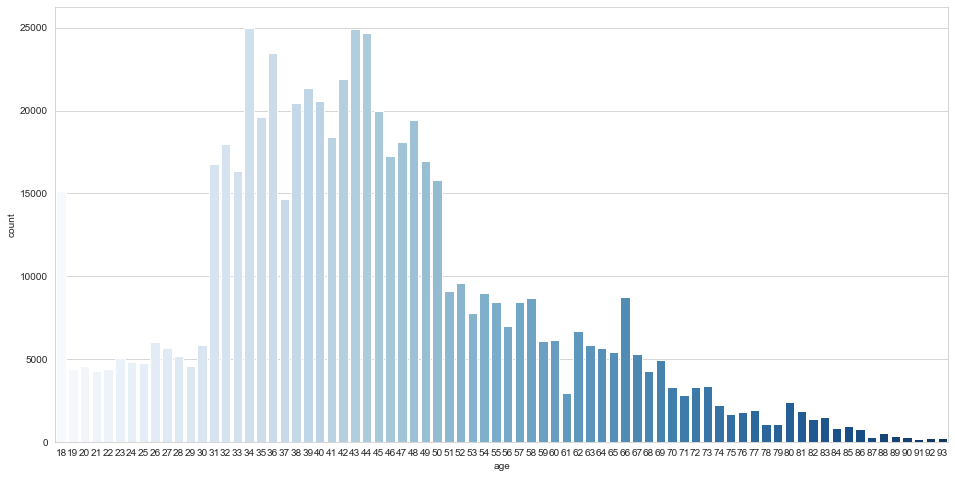

In [156]:
fig = plt.figure(figsize=[16, 8])
sns.set_style('whitegrid')
sns.countplot(x='age', data=df_transactions_customers_products_btoc, palette='Blues')

En termes de nombre d'achats, c'est la tranche des 30 - 50 ans qui réalisent le plus d'achats sur notre librairie généraliste en ligne 

## Répartition de l'age avec les categories

In [157]:
# Definition du df_age_CA
df_age_CA_btoc_categ = df_transactions_customers_products_btoc.groupby(
    ['age', 'categ'])['price'].sum()

# Dataframe
df_age_CA_btoc_categ = pd.DataFrame(df_age_CA_btoc_categ)

# rename colonne
df_age_CA_btoc_categ = df_age_CA_btoc_categ.rename(columns={
    'price': 'CA'})
# reset_index
df_age_CA_btoc_categ = df_age_CA_btoc_categ.reset_index()

<AxesSubplot:xlabel='age', ylabel='CA'>

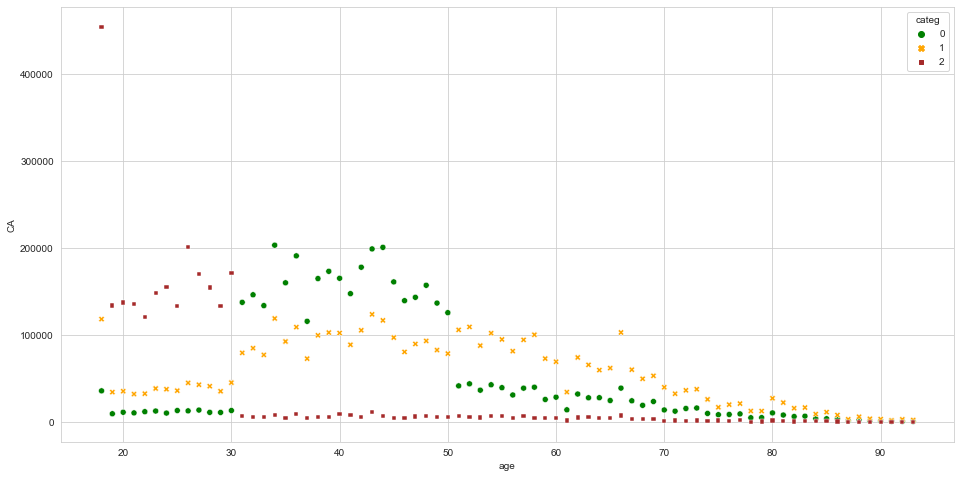

In [158]:
# visualisation scatter plot
fig = plt.figure(figsize=[16, 8])
sns.scatterplot(data=df_age_CA_btoc_categ, x="age", y="CA", hue="categ",style="categ",
    sizes=(20, 100), palette=['green','orange','brown'])

Nous observons des similitudes en fonction des catégories d'age, distinguons 3 classes:

* 18 à 30 ans > Les produits de categorie 2 sont les plus forts
* 30 à 50 ans > Les produits de categorie 0 sont les plus forts
* 50 ans et plus > Les produits de categorie 1 sont les plus forts

## CA réalisé en fonction des tranches d'age des clients

In [159]:
# pd.cut
df_age_CA_btoc_categ['age_range'] = pd.cut(
    x=df_age_CA_btoc_categ['age'], bins=(17, 31, 50, 94))

# groupby
df_age_CA_btoc_range = df_age_CA_btoc_categ.groupby(
    'age_range')['CA'].sum()

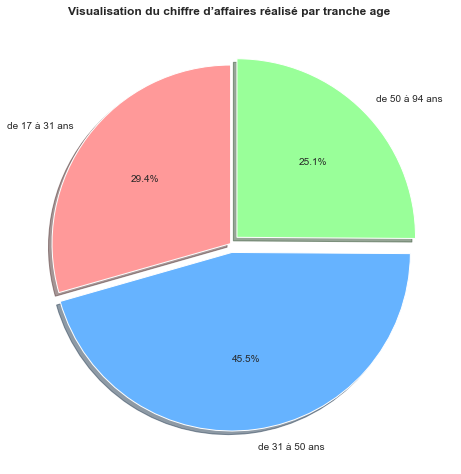

In [160]:
fig = plt.figure(figsize=[8, 12])
labels = 'de 17 à 31 ans', 'de 31 à 50 ans', 'de 50 à 94 ans'

sizes = [df_age_CA_btoc_range[0],
         df_age_CA_btoc_range[1],
         df_age_CA_btoc_range[2]]

explode = (0, 0.05, 0.05)
ax = fig.add_subplot()

# add colors
colors = ['#ff9999', '#66b3ff', '#99ff99']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title(
    'Visualisation du chiffre d’affaires réalisé par tranche age ', fontweight="bold")
plt.show()

In [161]:
#Affichage du CA par tranche d'age avec la fonction print()
print(f'Le chiffre d affaires réalisés par la tranche 17 à 31 ans est de : {round(df_age_CA_btoc_range[0],2)} euros')
print(f'Le chiffre d affaires réalisés par la tranche 31 à 51 ans est de : {round(df_age_CA_btoc_range[1],2)} euros')
print(f'Le chiffre d affaires réalisés par la tranche 51 à 94 ans est de : {round(df_age_CA_btoc_range[2],2)} euros')

Le chiffre d affaires réalisés par la tranche 17 à 31 ans est de : 3229440.3 euros
Le chiffre d affaires réalisés par la tranche 31 à 51 ans est de : 4990502.23 euros
Le chiffre d affaires réalisés par la tranche 51 à 94 ans est de : 2755238.13 euros


## CA en fonction du genre des clients

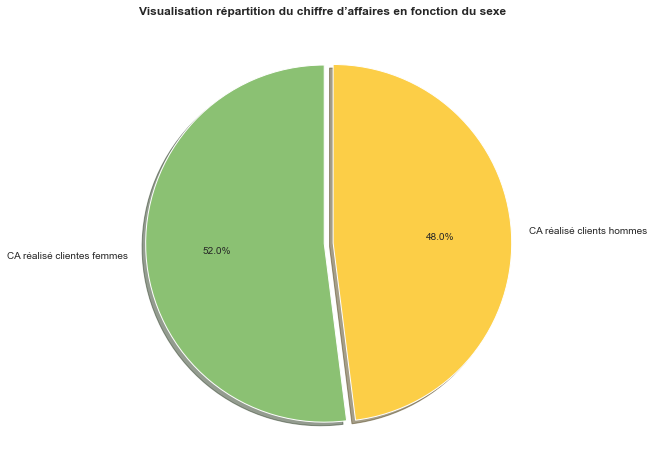

In [162]:
CA_femmes = df_transactions_customers_products_btoc.groupby('sex')['price'].sum()[0]
CA_hommes = df_transactions_customers_products_btoc.groupby('sex')['price'].sum()[1]

fig = plt.figure(figsize=[8, 12])
labels = 'CA réalisé clientes femmes', 'CA réalisé clients hommes'

sizes = [CA_femmes,
         CA_hommes]

explode = (0, 0.05)
ax = fig.add_subplot()

# add colors
colors = ['#8bc173', '#fcce47']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title(
    'Visualisation répartition du chiffre d’affaires en fonction du sexe ', fontweight="bold")
plt.show()

In [163]:
# Affichage CA réalisé en fonction du sexe avec la fonction print()
print(
    f'Le chiffre d’affaires réalisé par les femmes est de : {round(CA_femmes ,2)} euros')
print(
    f'Le chiffre d’affaires réalisé par les hommes est de : {round(CA_hommes ,2)} euros')

Le chiffre d’affaires réalisé par les femmes est de : 5707384.02 euros
Le chiffre d’affaires réalisé par les hommes est de : 5267796.64 euros


La part du CA réalisé par les femmes est plus importanet 52% contre 48% pour les hommes

## CA réalisé en fonction du sexe par produits

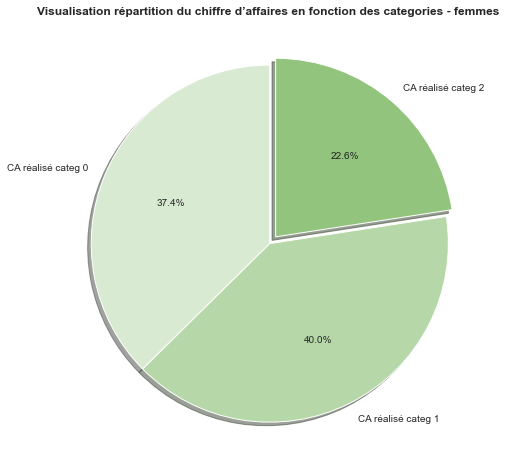

In [164]:
CA_femmes_categ_0 = df_transactions_customers_products_btoc.groupby(['sex', 'categ'])[
    'price'].sum()[0]
CA_femmes_categ_1 = df_transactions_customers_products_btoc.groupby(['sex', 'categ'])[
    'price'].sum()[1]
CA_femmes_categ_2 = df_transactions_customers_products_btoc.groupby(['sex', 'categ'])[
    'price'].sum()[2]

fig = plt.figure(figsize=[8, 12])
labels = 'CA réalisé categ 0', 'CA réalisé categ 1', 'CA réalisé categ 2'

sizes = [CA_femmes_categ_0,
         CA_femmes_categ_1,
         CA_femmes_categ_2]

explode = (0, 0, 0.05)
ax = fig.add_subplot()

# add colors
colors = ['#d9ead3', '#b6d7a8', '#93c47d']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title(
    'Visualisation répartition du chiffre d’affaires en fonction des categories - femmes ', fontweight="bold")
plt.show()

In [165]:
# Affichage CA réalisé par les femmes en fonction des categories avec la fonction print()
print(
    f'Le chiffre d’affaires réalisé par les femmes sur la categorie 0 est de : {round(CA_femmes_categ_0 ,2)} euros')
print(
    f'Le chiffre d’affaires réalisé par les femmes sur la categorie 1 est de : {round(CA_femmes_categ_1 ,2)} euros')
print(
    f'Le chiffre d’affaires réalisé par les femmes sur la categorie 2 est de : {round(CA_femmes_categ_2 ,2)} euros')

Le chiffre d’affaires réalisé par les femmes sur la categorie 0 est de : 2134058.29 euros
Le chiffre d’affaires réalisé par les femmes sur la categorie 1 est de : 2285170.48 euros
Le chiffre d’affaires réalisé par les femmes sur la categorie 2 est de : 1288155.25 euros


### CA réalisé par les hommes en fonction des categories

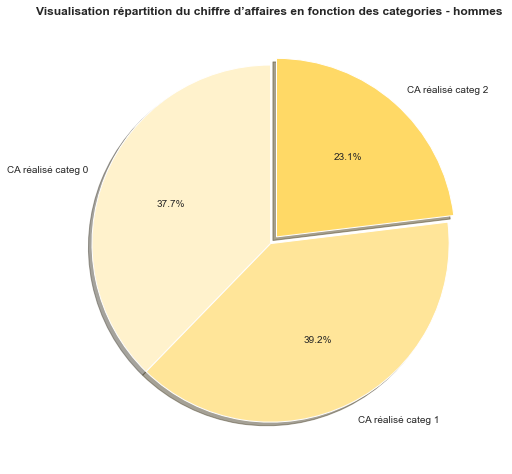

In [166]:
CA_hommes_categ_0 = df_transactions_customers_products_btoc.groupby(['sex', 'categ'])[
    'price'].sum()[3]
CA_hommes_categ_1 = df_transactions_customers_products_btoc.groupby(['sex', 'categ'])[
    'price'].sum()[4]
CA_hommes_categ_2 = df_transactions_customers_products_btoc.groupby(['sex', 'categ'])[
    'price'].sum()[5]

fig = plt.figure(figsize=[8, 12])
labels = 'CA réalisé categ 0', 'CA réalisé categ 1', 'CA réalisé categ 2'

sizes = [CA_hommes_categ_0,
         CA_hommes_categ_1,
         CA_hommes_categ_2]


explode = (0, 0,0.05)
ax = fig.add_subplot()

# add colors
colors = [ '#fff2cc', '#ffe599', '#ffd966']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title(
    'Visualisation répartition du chiffre d’affaires en fonction des categories - hommes ', fontweight="bold")
plt.show()

In [167]:
# Affichage CA réalisé par les hommes en fonction des categories avec la fonction print()
print(
    f'Le chiffre d’affaires réalisé par les hommes sur la categorie 0 est de : {round(CA_hommes_categ_0 ,2)} euros')
print(
    f'Le chiffre d’affaires réalisé par les hommes sur la categorie 1 est de : {round(CA_hommes_categ_1 ,2)} euros')
print(
    f'Le chiffre d’affaires réalisé par les hommes sur la categorie 2 est de : {round(CA_hommes_categ_2 ,2)} euros')

Le chiffre d’affaires réalisé par les hommes sur la categorie 0 est de : 1987624.92 euros
Le chiffre d’affaires réalisé par les hommes sur la categorie 1 est de : 2064262.51 euros
Le chiffre d’affaires réalisé par les hommes sur la categorie 2 est de : 1215909.21 euros


<AxesSubplot:xlabel='categ', ylabel='count'>

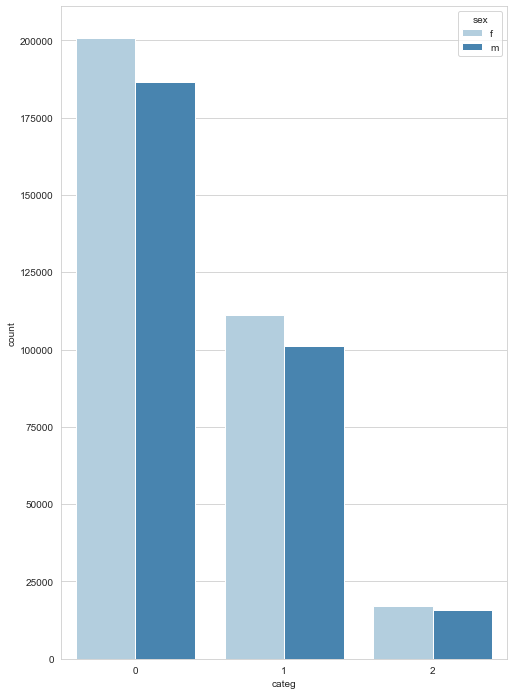

In [168]:
fig = plt.figure(figsize= [8,12])
sns.set_style('whitegrid')
sns.countplot(x='categ', hue='sex', data=df_transactions_customers_products_btoc, palette='Blues')

Les femmes achètent également plus de livres sur notre site que les hommes

# Correlation (BtoC)

## Le genre d'un client influence le choix  pour une catégorie de livre?

Ici on utilise la méthode **Chi-2** car les variables genre et catégorie sont qualitatives
<br>Dans un test d'indépendance de deux variable qualitatives, rejeter l'hypothèse nulle permettrait de mettre en evidence une dépendance entre les deux variables

In [169]:
# Hypothèses
# H0: l'hypothèse nulle: Les variables genre d'un client et catégories de produits ne sont pas corrélées
# H1: l'hypothèse alternative: Les variables genre d'un client et catégories de produits sont corrélées

In [170]:
df_transactions_customers_products_btoc['categ'] = df_transactions_customers_products_btoc['categ'].astype(
    'object')

In [171]:
df = df_transactions_customers_products_btoc

In [172]:
X = "categ"
Y = "sex"
c = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
tx = df[X].value_counts()
ty = df[Y].value_counts()
print("Voici notre tableau de contingence réel")
c

Voici notre tableau de contingence réel


sex,f,m
categ,,
0,200904,186589
1,111331,101017
2,16980,15868


In [173]:
# Calculons notre tableau de contingence théorique
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns = ["foo"]
ty.columns = ["foo"]
n = len(df)
indep = tx.dot(ty.T) / n

In [174]:
indep.sort_index(axis=1, inplace=True)
indep.sort_index(inplace=True)

In [175]:
indep

,f,m
0,201629.091062,185863.908938
1,110493.697251,101854.302749
2,17092.211687,15755.788313


In [176]:
# on calcul le Chi-2 grâce à la formule
mesure = (c-indep)**2/indep
xi_n = mesure.sum().sum()

In [177]:
print("Le Chi-2 ici, est de : {}".format(xi_n))

Le Chi-2 ici, est de : 20.200173796862927


In [178]:
ddl = (len(c)-1)*(len(c.columns)-1)
ddl

2

In [179]:
chi2, pvalue, dof, expected_freq = st.chi2_contingency(c)
# Chi2 est le résultat du Chi2
# dof est le nombre de degré de liberté
print("Nous avons bien un chi-2 égal à {}\nEt un degré de liberté égal à {}".format(chi2, dof))

Nous avons bien un chi-2 égal à 20.200173796862927
Et un degré de liberté égal à 2


*Methode 1:* La table du **Chi-2** 
<br>
<br>Pour un seuil de tolérance de 5% avec 2 degré de liberté, nous obtenons 10.59
<br>Le Chi-2 trouvé doit être inférieur à 10.59 pour qu'on puisse accepter l'hypthèse H0. Dans notre cas le Chi-2 vaut 20.20 il est donc très nettement supérieur à 10.59.
<br>On doit donc rejetter H0 et accepter H1 : **Il existe une corrélation entre le genre de la personne et la catégorie de livre**

In [180]:
 # La variable expected_freq représente notre tableau de contingence théorique
expected_freq

array([[201629.09106212, 185863.90893788],
       [110493.69725094, 101854.30274906],
       [ 17092.21168694,  15755.78831306]])

In [181]:
# Et la variable pvalue représente notre p-value
pvalue

4.1075985631484716e-05

In [182]:
# p value
print(
    f'Nous avons une pvalue égale à {pvalue*100}')

Nous avons une pvalue égale à 0.004107598563148472


*Methode 2:* La p-value
<br>
<br>La p-value est une varible essentiel, elle représente le pourcentage de chance de rejetter H0 à tort. 
<br>Ici la p-value est inférieure à 0.05, on peut donc conclure qu'on peut rejetter H0 au seuil de 5%.
<br>Notre p-value est de 0.000041, on peut donc rejetter sereinement H0 puisque les chances de rejetter H0 à tort sont de 0.0041%.
<br> **Nous concluons que H1 est vérifié et que les variables genre d'un client et catégories de produits sont corrélées**

In [183]:
mesure = (c-indep)**2/indep
mesure

sex,f,m
categ,,
0,2.607546,2.828720
1,6.344940,6.883125
2,0.736678,0.799164


In [184]:
xi_n = mesure.sum().sum()
xi_n

20.200173796862927

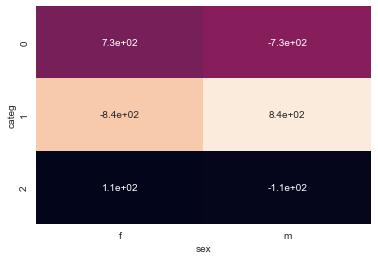

In [185]:
# Tableau de contingence coloré (heatmap)
sns.heatmap(mesure/xi_n, annot=indep-c , cbar=False)
plt.show()

Sur ce tableau de contingence coloré ("heatmap" en anglais) : plus la couleur est claire, plus l'écart entre la valeur
théorique attendue et la valeur réelle est significatif. A contrario, plus la couleur est foncée et plus l'écart entre la valeur théorique et la valeur réel est non significatif.
<br>
On voit bien que en ce qui concerne la categorie 2, le genre de la personne importe peu :
femmes comme homme choisissent cette categorie à part égale.
Ce qui n'est pas du tout le cas pour la categorie 1 qui montre un écart significatif entre la valeur théorique et la valeur réel

## Le lien entre l’âge des clients 

* Le montant total des achats
* La taille du panier moyen 
* Les catégories des livres achetés
* La fréquence d’achat

### L'age d'un client influence le montant total des achats?

Voici nos hypothèses :
* H0 : l'age n'est pas corrélé au montant total des achats
* H1 : l'age est corrélé au montant total des achats

In [186]:
# groupby
df_age_CA = df_transactions_customers_products_btoc.groupby(['age'])[
    'price'].sum()

# dataframe
df_age_CA = pd.DataFrame(df_age_CA)

# rename colonne
df_age_CA = df_age_CA.rename(columns={'price': 'CA'})

#reset_index
df_age_CA = df_age_CA.reset_index()

Text(0, 0.5, 'CA')

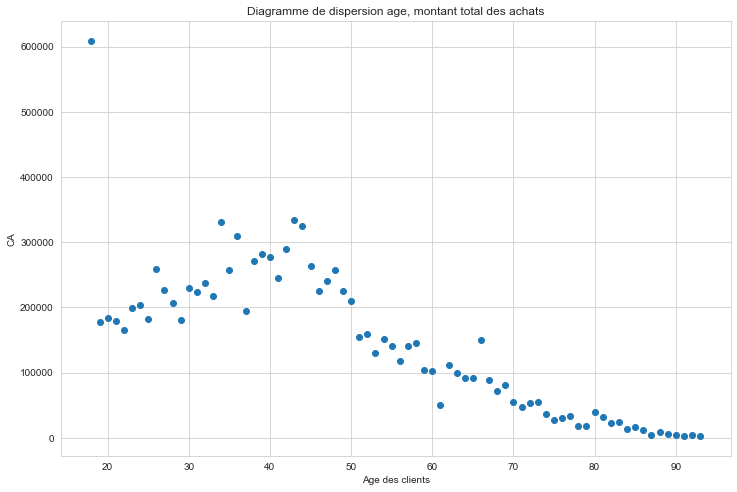

In [187]:
# On affiche le diagramme de dispersion
X = df_age_CA['age']
y = df_age_CA['CA']

# scatterplot
fig = plt.figure(figsize=[12, 8])
plt.scatter(X, y)
plt.title('Diagramme de dispersion age, montant total des achats')
plt.xlabel('Age des clients')
plt.ylabel('CA')

In [188]:
# Calculons le coefficient de Pearson
r, p_value = st.pearsonr(X, y)
print(f'Le coefficient de corrélation r est de : {round(r,2)}')
print(f'Sa p-value est de : {p_value}')

Le coefficient de corrélation r est de : -0.83
Sa p-value est de : 1.6992014238293582e-20


Ici on trouve un coefficient de corrélation d'environ -0.83, ce qui veut dire que les deux variables sont fortement corrélées negativement.
<BR> Plus on est jeune, plus le montant total des achats est élévé

In [189]:
# Déterminons maintenant la droite de régression linéaire
# Calcul de la régression linéaire
X = df_age_CA[['age']]
y = df_age_CA['CA']
X = X.assign(intercept = [1]*X.shape[0])
lr = sm.OLS(y, X).fit()
print(lr.summary2())

                    Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.686     
Dependent Variable:    CA                AIC:                 1897.9847 
Date:                  2022-04-24 16:32  BIC:                 1902.6462 
No. Observations:      76                Log-Likelihood:      -946.99   
Df Model:              1                 F-statistic:         164.6     
Df Residuals:          74                Prob (F-statistic):  1.70e-20  
R-squared:             0.690             Scale:               4.0003e+09
------------------------------------------------------------------------
             Coef.     Std.Err.     t     P>|t|     [0.025      0.975]  
------------------------------------------------------------------------
age        -4243.2558   330.7164 -12.8305 0.0000  -4902.2227  -3584.2890
intercept 379910.9712 19736.5943  19.2491 0.0000 340584.9486 419236.9939
------------------------------------------------------------------------

In [190]:
# On stock d'abord a et b dans les variables correspondantes :
a,b = lr.params['age'], lr.params['intercept']

Text(0, 0.5, 'CA')

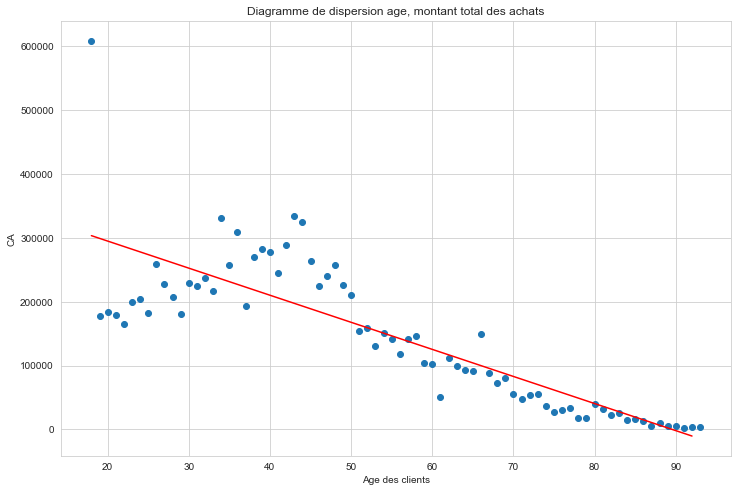

In [191]:
# On affiche le nuage de point avec la droite de régression linéaire
X = df_age_CA['age']
y = df_age_CA['CA']

# scatterplot
fig = plt.figure(figsize=[12, 8])
plt.plot(X, y,"o")
plt.plot(np.arange(min(X), max(X)),[a*x+b for x in np.arange(min(X), max(X))], c='red')
plt.title('Diagramme de dispersion age, montant total des achats')
plt.xlabel('Age des clients')
plt.ylabel('CA')

### L'age d'un client influence la taille du panier moyen ?
**Methode 1** : Analyse des corrélations pour deux variables quantitatives

In [195]:
# groupby
df_age_panier_moyen = df_transactions_customers_products_btoc.groupby(['age'])[
    'price'].mean()

# dataframe
df_age_panier_moyen = pd.DataFrame(df_age_panier_moyen)

# rename colonne
df_age_panier_moyen = df_age_panier_moyen.rename(
    columns={'price': 'panier moyen'})

# reset_index
df_age_panier_moyen = df_age_panier_moyen.reset_index()

Voici nos hypothèses :
H0 : l'age n'est pas corrélé à la taille du panier moyen
H1 : l'age est corrélé à la taille du panier moyen

Text(0, 0.5, 'panier moyen')

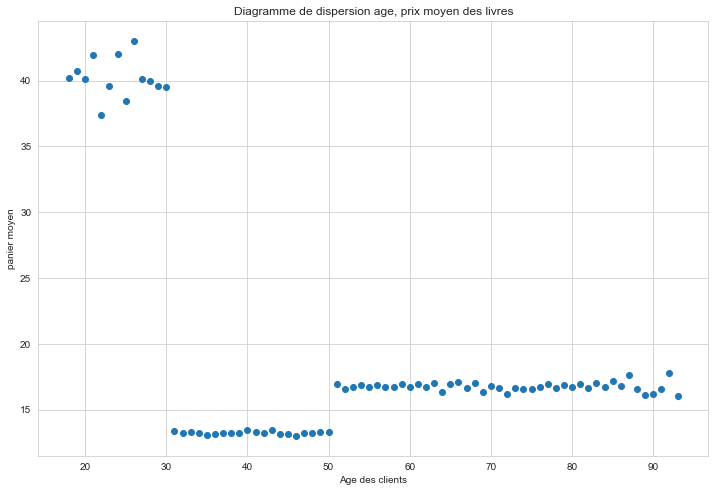

In [196]:
# On affiche le diagramme de dispersion
X = df_age_panier_moyen['age']
y = df_age_panier_moyen['panier moyen']

# scatterplot
fig = plt.figure(figsize=[12, 8])
plt.scatter(X, y)
plt.title('Diagramme de dispersion age, prix moyen des livres')
plt.xlabel('Age des clients')
plt.ylabel('panier moyen')

In [197]:
# Calculons le coefficient de Pearson
r, p_value = st.pearsonr(X, y)
print(f'Le coefficient de corrélation r est de : {round(r,2)}')
print(f'Sa p-value est de : {p_value}')

Le coefficient de corrélation r est de : -0.55
Sa p-value est de : 3.1822714466393764e-07


On peut conclure en regardant la p-value. En effet si celle-ci est inférieure au seuil
de probabilité alors on peut également rejetter l'hypothèse nulle.
Ici la p-value est très inférieure à 5%, donc **on rejette l'hypothèse H0**

**Methode 2** Analyse des corrélations pour une variable qualitative et une variable quantitative
<br>On transforme d'age en variable qualitative

<AxesSubplot:xlabel='age'>

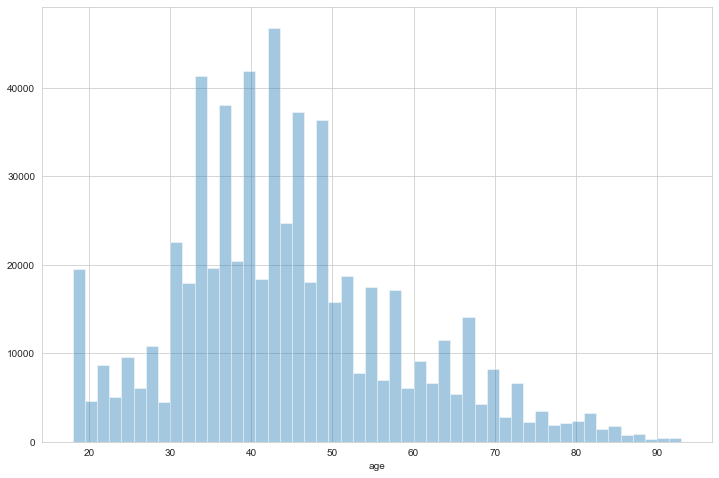

In [198]:
# distplot
fig = plt.figure(figsize=[12, 8])
sns.distplot(df_transactions_customers_products_btoc['age'],kde=False)

In [199]:
# création de categorie d'ages
df_age_panier_moyen.loc[(
    df_age_panier_moyen['age'] < 31), 'age_group'] ='moins de 31 ans'
df_age_panier_moyen.loc[(
    df_age_panier_moyen['age'] >= 31) & (
    df_age_panier_moyen['age'] < 50), 'age_group'] ='entre 31 ans et 50'
df_age_panier_moyen.loc[(
    df_age_panier_moyen['age'] >= 50), 'age_group'] ='plus de 50 ans'

In [200]:
# test d'égalité des variances
stats.levene(df_age_panier_moyen[df_age_panier_moyen.age_group == 'moins de 31 ans']['panier moyen'],
             df_age_panier_moyen[df_age_panier_moyen.age_group == 'entre 31 ans et 50']['panier moyen'],
             df_age_panier_moyen[df_age_panier_moyen.age_group == 'plus de 50 ans']['panier moyen'])

LeveneResult(statistic=11.333237552129702, pvalue=5.170740019539184e-05)

In [201]:
thirty_one_lower = df_age_panier_moyen[df_age_panier_moyen.age_group ==
                                       'moins de 31 ans']['panier moyen']
thirty_one_fifty = df_age_panier_moyen[df_age_panier_moyen.age_group ==
                                       'entre 31 ans et 50']['panier moyen']
fifty_older = df_age_panier_moyen[df_age_panier_moyen.age_group ==
                                  'plus de 50 ans']['panier moyen']

In [208]:
# One-way ANOVA
f_statistic, p_value = stats.f_oneway(thirty_one_lower,thirty_one_fifty,fifty_older)
f_statistic, p_value

(5546.006578346093, 1.8383244547335514e-80)

Le panier moyen en fonction des categories de livre n'est pas le meme, Nous pouvons conclure que la taille du panier moyen diffère selon l'age, **nous rejetons l'hypothèse H0** 

### L'age d'un client influence le choix pour la catégorie des livres achetés?

**Methode 1** On utilise la méthode **ANOVA** car les variables age et catégorie sont quantitatives et qualitatives

In [203]:
# Hypothèses
# H0: l'hypothèse nulle: Les variables age d'un client et la catégorie des livres achetés ne sont pas corrélées
# H1: l'hypothèse alternative: Les variables age d'un client et la catégorie des livres achetés sont corrélées

In [221]:
df=df_transactions_customers_products_btoc

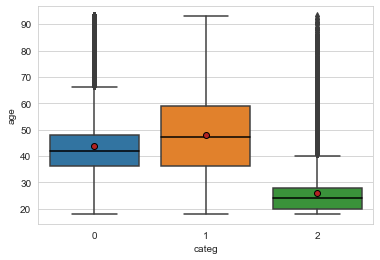

In [254]:
# Analyse graphique
Y = "categ"
X = "age"
medianprops = {'color': "black"}
meanprops = {'marker': 'o', 'markeredgecolor': 'black',
             'markerfacecolor': 'firebrick'}
sns.boxplot(y=df[X], x=df[Y], showmeans=True, meanprops=meanprops,
            medianprops=medianprops)
plt.show()

In [265]:
# Moyenne d'age pour chaque categorie
df.groupby(Y)[X].mean()

categ
0    43.794574
1    47.802913
2    25.965508
Name: age, dtype: float64

In [277]:
modalites = df[Y].unique()
groupes = []
mean_list = []
for m in modalites:
    groupes.append(df[df[Y]==m][X])
    mean_list.append(df[df[Y]==m][X].mean())

In [278]:
SCT = ((df[Y] - moyenne_globale)**2).sum()
SCT

1212599461.295516

In [279]:
SCR_list = []
for k in range(len(mean_list)):
    SCR_list.append(((groupes[k]-mean_list[k])**2).sum())
SCR = np.sum(SCR_list)
print(SCR)

107572335.551381


In [280]:
SCE_list = []
for k in range(len(mean_list)):
    SCE_list.append(((mean_list[k]-moyenne_globale)**2)*len(groupes[k]))
SCE = np.sum(SCE_list)
print(SCE)

13741901.635650847


In [281]:
print("On a bien SCE+SCR ({}) qui est égal à SCT ({})".format(round
(SCE+SCR, 2),round(SCT, 2)))

On a bien SCE+SCR (121314237.19) qui est égal à SCT (1212599461.3)


In [282]:
# Calcul de la moyenne d'age pour l'ensemble des categories (tous niveaux confondus)
moyenne_globale = df[X].mean()
print("La moyenne globale est de {}".format(moyenne_globale))

La moyenne globale est de 44.21423321726788


In [283]:
n = len(df[X])
k = len(modalites)
ddl_inter = (k - 1)
ddl_intra = (n - k)
print("Nous avons un degré de liberté inter-groupes de {} et un degré de liberté intra-groupes de {}"
.format(ddl_inter, ddl_intra))

Nous avons un degré de liberté inter-groupes de 2 et un degré de liberté intra-groupes de 632686


**Le test de Fisher**

In [284]:
# Calculons la F_statistic
f_statistic = (SCE/(ddl_inter))/(SCR/(ddl_intra))
print("La valeur F_statistic vaut {}".format(round(f_statistic, 2)))

La valeur F_statistic vaut 40411.45


In [285]:
eta_carre = SCE / SCT
eta_carre

0.01133259750995542

In [286]:
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [287]:
linear_model = ols('age ~ C(categ)', data=df).fit()
table = sm.stats.anova_lm(linear_model, typ=2)
# Afficher les résultats de la table d'ANOVA
print(table)

                sum_sq        df             F  PR(>F)
C(categ)  1.374190e+07       2.0  40411.453064     0.0
Residual  1.075723e+08  632686.0           NaN     NaN


In [288]:
pvalue = linear_model.f_pvalue
print("Ici la p-value est égale à {}".format(pvalue))

Ici la p-value est égale à 0.0


In [289]:
# On affiche la régression linéaire correspondante
print(linear_model.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.113       
Dependent Variable: age              AIC:                5044952.2187
Date:               2022-04-25 11:49 BIC:                5044986.2919
No. Observations:   632689           Log-Likelihood:     -2.5225e+06 
Df Model:           2                F-statistic:        4.041e+04   
Df Residuals:       632686           Prob (F-statistic): 0.00        
R-squared:          0.113            Scale:              170.02      
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|   [0.025   0.975] 
---------------------------------------------------------------------
Intercept         43.7946   0.0209 2090.7209 0.0000  43.7535  43.8356
C(categ)[T.1]      4.0083   0.0352  113.8534 0.0000   3.9393   4.0773
C(categ)[T.2]    -17.8291   0.0749 -237.9348 0.0000 -17.9759 -17.6822
---------------------------------------

In [290]:
seuil = 0.05
# Conclusion
if pvalue > seuil:
    print("On ne peux pas rejetter H0: il n'y a pas de corrélation")
else:
    print("On rejette H0 : il y a une corrélation")

On rejette H0 : il y a une corrélation


Vérifions les trois hypothèses du modèle linéaire à vérifier pour que l'ANOVA soit valide
<BR>
<BR>Ce jeu de données réponds notamment aux trois hypothèses à vérifier pour pouvoir réaliser une ANOVA.
* Les résidus sont normalement distribués (c'est à dire qu'ils suivent une loi normale)
* Les variances des K population sont égales entre elles (hypothèse d'homoscédasticité)
* Des échantillons aléatoires simple d'effectifs sont prélevés dans les populations indépendamment les une des autres

In [291]:
#le test de Shapiro-Wilk : Test de la distribution normale des résidus
w, pvalue = st.shapiro(linear_model.resid)
print("Sapiro-Wilk : {}, pvalue : {}".format(w, pvalue))

Sapiro-Wilk : 0.9709345102310181, pvalue : 0.0


La pvalue étant inférieure au seuil de 5%, on peut en conclure que la **distribution des résidus ne suit pas une loi
normale**

**Homoscédasticité**
<br>
<br>Pour teste l'homoscédasticité on peut utiliser le test de Levene ou le test de Bartlett. Testons les deux
pour l'exemple.

In [292]:
#Homoscédasticité : Test de Levene
levene, pvalue = st.levene(groupes[0], groupes[1], groupes[2])
print("Levene : {}, pvalue : {}".format(levene, pvalue))

Levene : 23879.92163366652, pvalue : 0.0


In [293]:
#Homoscédasticité : Test de Bartlett
bartlett, pvalue = st.bartlett(groupes[0], groupes[1], groupes[2])
print("Bartlett : {}, pvalue : {}".format(bartlett, pvalue))

Bartlett : 33008.9103341906, pvalue : 0.0


Dans les deux cas, la p-value est inférieure au seuil de 5%, on peut en conclure que l'hypothèse d'homoscédasticité est refusée.

**Methode 2** On utilise la méthode **Chi-2** car les variables genre et catégorie sont qualitatives

In [297]:
# Hypothèses
# H0: l'hypothèse nulle: Les variables age d'un client et la catégorie des livres achetés ne sont pas corrélées
# H1: l'hypothèse alternative: Les variables age d'un client et la catégorie des livres achetés sont corrélées

In [298]:
# création de categorie d'ages
df.loc[(df['age'] < 31), 'age_group'] ='moins de 31 ans'
df.loc[(df['age'] >= 31) & (df['age'] < 50), 'age_group'] ='entre 31 ans et 50'
df.loc[(df['age'] >= 50), 'age_group'] ='plus de 50 ans'

In [300]:
df

,Date,id_prod,date,session_id,client_id,sex,birth,price,categ,ANNEE,MOIS,JOUR,age,age_group
0,2022-05-20,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,May,Friday,36,entre 31 ans et 50
1,2021-07-20,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,f,1986,4.18,0,2021,July,Tuesday,36,entre 31 ans et 50
2,2022-08-20,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,f,1986,4.18,0,2022,August,Saturday,36,entre 31 ans et 50
3,2022-05-27,0_1518,2022-05-27 12:41:28.779302,s_214775,c_7456,f,1985,4.18,0,2022,May,Friday,37,entre 31 ans et 50
4,2021-11-27,0_1518,2021-11-27 12:41:28.779302,s_125853,c_7456,f,1985,4.18,0,2021,November,Saturday,37,entre 31 ans et 50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632684,2023-01-26,1_408,2023-01-26 06:52:02.225335,s_332548,c_7402,m,1945,35.24,1,2023,January,Thursday,77,plus de 50 ans
632685,2022-11-26,1_408,2022-11-26 06:52:02.225335,s_302962,c_7402,m,1945,35.24,1,2022,November,Saturday,77,plus de 50 ans
632686,2021-09-26,1_408,2021-09-26 06:52:02.225335,s_95708,c_7402,m,1945,35.24,1,2021,September,Sunday,77,plus de 50 ans
632687,2022-02-19,2_81,2022-02-19 14:51:58.078656,s_167662,c_7616,m,1993,86.99,2,2022,February,Saturday,29,moins de 31 ans


In [314]:
Y = "categ"
X = "age_group"
c = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
tx = df[X].value_counts()
ty = df[Y].value_counts()
print("Voici notre tableau de contingence réel")
c

Voici notre tableau de contingence réel


categ,0,1,2
age_group,,,
entre 31 ans et 50,287531,88962,1411
moins de 31 ans,16697,28087,29879
plus de 50 ans,83265,95299,1558


In [315]:
# Calculons notre tableau de contingence théorique
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns = ["foo"]
ty.columns = ["foo"]
n = len(df)
indep = tx.dot(ty.T) / n

In [316]:
indep.sort_index(axis=1, inplace=True)
indep.sort_index(inplace=True)

In [317]:
indep

,0,1,2
entre 31 ans et 50,231448.870886,126835.077885,19620.051229
moins de 31 ans,45727.663764,25058.976407,3876.359829
plus de 50 ans,110316.465350,60453.945708,9351.588942


In [318]:
# on calcul le Chi-2 grâce à la formule
mesure = (c-indep)**2/indep
xi_n = mesure.sum().sum()

In [319]:
print("Le Chi-2 ici, est de : {}".format(xi_n))

Le Chi-2 ici, est de : 268232.7751875388


In [320]:
ddl = (len(c)-1)*(len(c.columns)-1)
ddl

4

In [321]:
chi2, pvalue, dof, expected_freq = st.chi2_contingency(c)
# Chi2 est le résultat du Chi2
# dof est le nombre de degré de liberté
print("Nous avons bien un chi-2 égal à {}\nEt un degré de liberté égal à {}".format(chi2, dof))

Nous avons bien un chi-2 égal à 268232.7751875388
Et un degré de liberté égal à 4


In [322]:
# p value
print(
    f'Nous avons une pvalue égale à {pvalue*100}')

Nous avons une pvalue égale à 0.0


In [323]:
mesure = (c-indep)**2/indep
mesure

categ,0,1,2
age_group,,,
entre 31 ans et 50,13589.200906,11308.937972,16899.525021
moins de 31 ans,18430.406655,365.893911,174425.833936
plus de 50 ans,6633.477380,20084.343452,6495.155954


In [324]:
xi_n = mesure.sum().sum()
xi_n

268232.7751875388

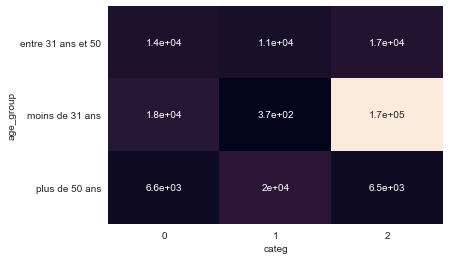

In [326]:
# Tableau de contingence coloré (heatmap)
sns.heatmap(mesure/xi_n, annot=mesure , cbar=False)
plt.show()

Sur ce tableau de contingence coloré ("heatmap" en anglais) : plus la couleur est claire, plus l'écart entre la valeur
théorique attendue et la valeur réelle est significatif. A contrario, plus la couleur est foncée et plus l'écart entre la valeur théorique et la valeur réel est non significatif.
<br>
On voit bien que en ce qui concerne la categorie 2, le genre de la personne importe peu :
femmes comme homme choisissent cette categorie à part égale.
Ce qui n'est pas du tout le cas pour la categorie 1 qui montre un écart significatif entre la valeur théorique et la valeur réel